In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib  import colors
import seaborn as sns
import geopandas as gpd

import random

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import time

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

%matplotlib inline

# dataset

In [2]:
df_listing=pd.read_csv('./SF/listings_full.csv')
print(df_listing.shape)
[print(i) for i in df_listing.columns];

(8533, 106)
id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_night

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
random.seed(100)

pd.set_option('display.max_columns', len(df_listing.columns)) # To view all columns
pd.set_option('display.max_rows', 100)

## date_last_scraped

In [4]:
date_last_scraped=pd.to_datetime(df_listing['last_scraped'][1])
date_last_scraped

Timestamp('2019-12-04 00:00:00')

# helper functions

In [5]:
def catogory_plot(df, col, title, fsize=(15,5)):
    plt.figure(figsize=fsize)
    df[col].value_counts(sort=True).plot(kind='bar')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

In [6]:
def hist_plot(df, col, title, figs=(15,5), nbin=10):
    plt.figure(figsize=figs)
    df[col].hist(bins=nbin)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.title(title)
    plt.show()

In [7]:
def distribution_plot(df, col, title):
    sns.set(color_codes=True)
    sns.kdeplot(df[col], shade=True, color='b', label=col)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.title(title)
    plt.show()

In [8]:
def learning_curve_plot(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,train_sizes= np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title('Learning Curve')
    # axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
    axes.legend(loc="best")

In [9]:
def into_bins(col, bins, labels, nan_label='unknown' ):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    
    df[col] = df[col].cat.add_categories(nan_label)
    df[col].fillna(nan_label, inplace =True) 

    df[col] = df[col].astype('str')
    

In [10]:
def pri_missing_perc(col):
    print(" {} ({}%) missing values in {} ".format(df[col].isnull().sum(),df[col].isnull().sum()/df.shape[0]*100, col))


In [11]:
def dummied_df(df):
    cat_cols=df.select_dtypes(include=['object']).copy().columns 
    print(cat_cols)
    for col in cat_cols:
        df=pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    return df

In [12]:
# get correlation matrix and generate heatmap
def corr_heatmap(A,mode,cmap='bwr'):
    
    if mode=='df':
        df_dummy=A
        corr = df_dummy.corr()
    elif mode=='c':
        corr=A
    
    print(corr.shape)
    
    vmax=corr[corr != 1.0].max().max()
    vmin=corr[corr != -1.0].min().min()

    #  Set Up Mask To Hide Upper Triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True

    # Create Heatmap in Seaborn
    fig, ax = plt.subplots(figsize=(25, 25)) 
    heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, 
                          linewidths=.2, cbar_kws={"shrink": .5}, 
                          vmax=1.0,vmin=-1.0);

    #add the column names as labels
    ax.set_yticklabels(corr.columns, rotation = 0)
    ax.set_xticklabels(corr.columns)
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


In [13]:
# drop columns with percentage of missing data over a certain ratio
def dropManyNANcol(df, ratio):
    dict={}
    for col in df.columns:
        a=df[col].isnull().sum()/df.shape[0]
        if a>=ratio:
            dict[col]=a
            
    a=df.shape[1]
    for key in dict.keys():
        if key in df.columns:
            print('dropped feature {}'.format(key))
            df.drop([key],axis=1, inplace=True)
            
    print('Dropped {} columns with missing data over {}%'.format(a-df.shape[1], ratio*100))
    return df

In [14]:
# drop columns with all the same values
def dropSameValuecol(df):
    dict={}
    for col in df.columns:
        dict[col]=df[col].value_counts().shape[0]

    a=df.shape[1]
    
    for key in dict.keys():
        if dict[key]==1:
            print('dropped feature {}'.format(key))
            df.drop([key],axis=1, inplace=True)

    print('Dropped {} columns with only one value'.format(a-df.shape[1]))
    return df

In [15]:
# haven't use it yet
def del_outliers(df, Y='price'):
    big_out = []
    small_out = []
    data_array = np.array(df[Y])
    mean = np.mean(data_array)
    std = np.std(data_array)

    for i in range(0, len(data_array)):
        if data_array[i] - mean > 1.96 * std:
            big_out.append(data_array[i])
        if data_array[i] - mean < -1.96 * std:
            small_out.append(data_array[i])
    big_thred = sorted(big_out)[0]
    small_thred = sorted(small_out)[-1]

    df = df[df[Y] < big_thred]
    df = df[df[Y] > small_thred]

    return df

In [16]:
def pre_data(X,y, perc):
    '''
    INPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    
    OUTPUT
    X'
    
    This function cleans df using the following steps to produce X':
    1. For each numeric variable in X, fill the column with the mean value of the column.
    2. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    print('dataset size after pre-processing: {}'.format(df.shape))

    # split data into train and test
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=perc, random_state=101)
    
    # scale X_train
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # get feature list
    col_list=X.columns
    
    return X_train, y_train, X_test, y_test, col_list

# Part 1: Dropping based on initial analysis
1. free text columns will be dropped for now since no NLP involved in this project
2. other columns which are not useful for predicting price (e.g. url, host name, id, are unrelated to the property).
3. columns that contain >50% missing values
4. columns that dominates by a value (skew)

In [17]:
col_list= [
#  'id', 
#  'listing_url', 
#  'scrape_id', 
#  'last_scraped', 
#  'name', 
#  'summary',
#  'space', 
#  'description', 
 'experiences_offered', 
#  'neighborhood_overview',
#  'notes', 
#  'transit', 
#  'access',
#  'interaction',
#  'house_rules',
#  'thumbnail_url', 
#  'medium_url', 
#  'picture_url',
#  'xl_picture_url', 
#  'host_id', 
#  'host_url', 
#  'host_name', 
    'host_since',
    'price',
#  'host_location', 
#  'host_about', 
    'host_response_time',
    'host_response_rate', 
    'host_acceptance_rate',  
    'host_is_superhost',
#  'host_thumbnail_url', 
#  'host_picture_url', 
#  'host_neighbourhood',
    'host_listings_count', 
    'host_total_listings_count',
#  'host_verifications', 
    'host_has_profile_pic', 
    'host_identity_verified',
#  'street', 
    'neighbourhood', 
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed', 
#  'city', 
#  'state', 
    'zipcode', 
#  'market',
#  'smart_location', 
#  'country_code', 
#  'country', 
#  'latitude', 
#  'longitude',
#  'is_location_exact', 
    'property_type', 
    'room_type', 
    'bathrooms',
    'accommodates',
    'bedrooms', 
    'beds', 
    'bed_type', 
    'amenities', 
    'square_feet', 
    'weekly_price', 
    'monthly_price', 
    'security_deposit',
    'cleaning_fee', 
    'guests_included', 
    'extra_people', 
    'minimum_nights',
    'maximum_nights',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
#  'calendar_updated', 
#  'has_availability',
    'availability_30', 
    'availability_60',
    'availability_90',
    'availability_365', 
#  'calendar_last_scraped', 
    'number_of_reviews',
    'number_of_reviews_ltm',
    'reviews_per_month',
    'first_review', 
    'last_review', 
    'review_scores_rating',
    'review_scores_accuracy', 
    'review_scores_cleanliness',
    'review_scores_checkin', 
    'review_scores_communication',
    'review_scores_location', 
    'review_scores_value', 
#  'requires_license',
#  'license', 
#  'jurisdiction_names', 
    'instant_bookable',
    'is_business_travel_ready',
    'cancellation_policy' ,
#  'require_guest_profile_picture',
#  'require_guest_phone_verification',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms'
]

df=df_listing[col_list]

df=dropManyNANcol(df,0.5)

df=dropSameValuecol(df)


dropped feature host_acceptance_rate
dropped feature neighbourhood_group_cleansed
dropped feature square_feet
dropped feature weekly_price
dropped feature monthly_price
Dropped 5 columns with missing data over 50.0%
dropped feature experiences_offered
dropped feature is_business_travel_ready
Dropped 2 columns with only one value


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
# drop rows with missing price
print("{}% of data have list prices".format(df.dropna(subset=['price'], axis=0).shape[0]/df.shape[0]*100))
df=df.dropna(subset=['price'], axis=0)

100.0% of data have list prices


In [19]:
print(df.shape)
[print(i) for i in df_listing.columns]

(8533, 54)
id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## analysis/drop correlated features 

In [20]:
drop_corr_list=[]

#### There are two columns related to number of listings of each host. 

In [21]:
corr_list=['host_listings_count',
           'host_total_listings_count',
           'calculated_host_listings_count',
           'calculated_host_listings_count_entire_homes',
           'calculated_host_listings_count_private_rooms',
           'calculated_host_listings_count_shared_rooms']

df[corr_list].corr()

,host_listings_count,host_total_listings_count,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
host_listings_count,1.000000,1.000000,0.812863,0.899848,0.047711,-0.035297
host_total_listings_count,1.000000,1.000000,0.812863,0.899848,0.047711,-0.035297
calculated_host_listings_count,0.812863,0.812863,1.000000,0.970552,0.549725,0.008039
calculated_host_listings_count_entire_homes,0.899848,0.899848,0.970552,1.000000,0.340552,-0.072907
calculated_host_listings_count_private_rooms,0.047711,0.047711,0.549725,0.340552,1.000000,0.095030
calculated_host_listings_count_shared_rooms,-0.035297,-0.035297,0.008039,-0.072907,0.095030,1.000000


#### As entire_homes, private_rooms, and 'shared rooms' are three types of listing. One interesting point to check is the correlation between total listing and the sum of three subtype listings.
results show that they are hightly correlated. So counts of those three types of listing will be dropped as well.

In [22]:
corr_list=['host_listings_count',
           'host_total_listings_count',
           'calculated_host_listings_count'
           ]

# Create the pandas DataFrame 
temp = pd.DataFrame() 
temp['sum']=df['calculated_host_listings_count_entire_homes']+df['calculated_host_listings_count_private_rooms']+df['calculated_host_listings_count_shared_rooms']
temp[corr_list]=df[corr_list]

temp.corr()

,sum,host_listings_count,host_total_listings_count,calculated_host_listings_count
sum,1.000000,0.813451,0.813451,0.999393
host_listings_count,0.813451,1.000000,1.000000,0.812863
host_total_listings_count,0.813451,1.000000,1.000000,0.812863
calculated_host_listings_count,0.999393,0.812863,0.812863,1.000000


In [23]:
drop_corr_list.append(['host_listings_count', 
                       'calculated_host_listings_count',
                       'calculated_host_listings_count_entire_homes',
                       'calculated_host_listings_count_entire_homes',
                       'calculated_host_listings_count_private_rooms',
                       'calculated_host_listings_count_shared_rooms'])

#### There are 6 columns related to minimum and maximum number of night stays.

* 'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights' presumably refers to the fact that min/max night stays can vary over the year.
* We need to find two best features for max stay and min stay.
* correlation matrix showed that 'minimum_nights', 'minimum_minimum_nights','maximum_minimum_nights' and 'minimum_nights_avg_ntm' are highly correlated (almost the same). So I am using the most common used one 'minimum_nights' here. 
* maximum nights is highly correlated with minimum nights.
* Through 'minimum_maximum_nights', 'maximum_maximum_nights' and 'maximum_nights_avg_ntm'  are hightly correlated, but they are not correlated with maximum nights.

In [24]:
corr_list=['minimum_nights',
    'maximum_nights',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm']

df[corr_list].corr()

,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
minimum_nights,1.000000,0.999999,1.000000,1.000000,0.023046,0.023046,1.000000,0.023046
maximum_nights,0.999999,1.000000,0.999999,0.999999,0.023058,0.023058,0.999999,0.023058
minimum_minimum_nights,1.000000,0.999999,1.000000,1.000000,0.023046,0.023046,1.000000,0.023046
maximum_minimum_nights,1.000000,0.999999,1.000000,1.000000,0.023046,0.023046,1.000000,0.023046
minimum_maximum_nights,0.023046,0.023058,0.023046,0.023046,1.000000,1.000000,0.023046,1.000000
maximum_maximum_nights,0.023046,0.023058,0.023046,0.023046,1.000000,1.000000,0.023046,1.000000
minimum_nights_avg_ntm,1.000000,0.999999,1.000000,1.000000,0.023046,0.023046,1.000000,0.023046
maximum_nights_avg_ntm,0.023046,0.023058,0.023046,0.023046,1.000000,1.000000,0.023046,1.000000


In [25]:
drop_corr_list.append(['minimum_minimum_nights',
                       'maximum_minimum_nights',
                       'minimum_nights_avg_ntm',
                       'maximum_nights',
                       'minimum_maximum_nights',
                       'maximum_maximum_nights'])

#### there are 3 features related to number of reviews.
Only 'number_of_reviews' will be kept in this study.

In [26]:
corr_list=['number_of_reviews','number_of_reviews_ltm', 'reviews_per_month']
df[corr_list].corr()

,number_of_reviews,number_of_reviews_ltm,reviews_per_month
number_of_reviews,1.000000,0.760181,0.633926
number_of_reviews_ltm,0.760181,1.000000,0.862470
reviews_per_month,0.633926,0.862470,1.000000


In [27]:
drop_corr_list.append(['number_of_reviews_ltm', 'reviews_per_month'])

#### Several features related to detailed aspects of a listing.
* review_scores_rating, review_scores_accuracy and review_scores_value are hightly correlated.
* review_scores_cleanliness is more related to review_scores_rating than review_scores_accuracy and review_scores_value.
* review_scores_communication is more correlated with other features than review_scores_checkin. 

In [28]:
corr_list=['review_scores_rating', 
           'review_scores_accuracy', 
           'review_scores_cleanliness', 
           'review_scores_checkin',  
           'review_scores_communication', 
           'review_scores_location', 
           'review_scores_value'] 
df[corr_list].corr()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
review_scores_rating,1.000000,0.714605,0.660364,0.485594,0.635203,0.455536,0.680561
review_scores_accuracy,0.714605,1.000000,0.583867,0.472369,0.560656,0.360923,0.579862
review_scores_cleanliness,0.660364,0.583867,1.000000,0.385636,0.483285,0.296220,0.529265
review_scores_checkin,0.485594,0.472369,0.385636,1.000000,0.551807,0.268449,0.409263
review_scores_communication,0.635203,0.560656,0.483285,0.551807,1.000000,0.310523,0.512218
review_scores_location,0.455536,0.360923,0.296220,0.268449,0.310523,1.000000,0.431430
review_scores_value,0.680561,0.579862,0.529265,0.409263,0.512218,0.431430,1.000000


#### cleanliness, checkin, communication and location are just sub categories of reviwing. More investigations needed, as follows. 

In [29]:
corr_list=['review_scores_rating', 
           'review_scores_accuracy',  
           'review_scores_value'
           ]

# Create the pandas DataFrame 
temp = pd.DataFrame() 
temp['sum']=df['review_scores_cleanliness']+df['review_scores_checkin']+df['review_scores_communication']+df['review_scores_location']
temp[corr_list]=df[corr_list]

temp.corr()

,sum,review_scores_rating,review_scores_accuracy,review_scores_value
sum,1.000000,0.768652,0.678395,0.648549
review_scores_rating,0.768652,1.000000,0.714605,0.680561
review_scores_accuracy,0.678395,0.714605,1.000000,0.579862
review_scores_value,0.648549,0.680561,0.579862,1.000000


#### review_scores_value is more correlated with the sum of the four than any single one of them. But I decided to keep those sub-categories for now as the correlation is 0.648549	 which is not too high. 

In [30]:
drop_corr_list.append(['review_scores_rating',
                       'review_scores_accuracy',
                       'review_scores_communication'])

#### four features related to availability in the future
only keep availability_90 since it's highly correlated with the other three. 

In [31]:
corr_list=['availability_30', 
           'availability_60', 
           'availability_90', 
           'availability_365']
df[corr_list].corr()

,availability_30,availability_60,availability_90,availability_365
availability_30,1.000000,0.903922,0.817036,0.481813
availability_60,0.903922,1.000000,0.964945,0.588934
availability_90,0.817036,0.964945,1.000000,0.651648
availability_365,0.481813,0.588934,0.651648,1.000000


In [32]:
drop_corr_list.append(['availability_30', 
                       'availability_60', 
                       'availability_365'])

#### three features descripbing how many people the property could accommodate
accommodates is more related with the other two, it will be used here. 

In [33]:
corr_list=['accommodates', 
           'beds',
           'bedrooms',
           'guests_included']

df[corr_list].corr()

,accommodates,beds,bedrooms,guests_included
accommodates,1.000000,0.797325,0.758623,0.564943
beds,0.797325,1.000000,0.729615,0.487170
bedrooms,0.758623,0.729615,1.000000,0.496879
guests_included,0.564943,0.487170,0.496879,1.000000


In [34]:
drop_corr_list.append(['bedrooms','beds','guests_included']) 

drop_corr_list

[['host_listings_count',
  'calculated_host_listings_count',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_private_rooms',
  'calculated_host_listings_count_shared_rooms'],
 ['minimum_minimum_nights',
  'maximum_minimum_nights',
  'minimum_nights_avg_ntm',
  'maximum_nights',
  'minimum_maximum_nights',
  'maximum_maximum_nights'],
 ['number_of_reviews_ltm', 'reviews_per_month'],
 ['review_scores_rating',
  'review_scores_accuracy',
  'review_scores_communication'],
 ['availability_30', 'availability_60', 'availability_365'],
 ['bedrooms', 'beds', 'guests_included']]

#### other types of charges are shown to be not relevant

In [35]:
corr_list=['security_deposit',
           'cleaning_fee', 
           'extra_people'
          ]

for col in corr_list:
    df[col]=df[col].str[1:].str.replace(',', '').astype('float64')

df[corr_list].corr()

,security_deposit,cleaning_fee,extra_people
security_deposit,1.000000,0.329502,0.064364
cleaning_fee,0.329502,1.000000,0.034263
extra_people,0.064364,0.034263,1.000000


#### Neighbourhood Related Features are not numerical, thus, they will be studied later.
    'neighbourhood', 
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed'  -- drop due to too many missing values, 
    'zipcode', 

#### delete correlated columns from dataset

In [36]:
drop_corr_list

[['host_listings_count',
  'calculated_host_listings_count',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_private_rooms',
  'calculated_host_listings_count_shared_rooms'],
 ['minimum_minimum_nights',
  'maximum_minimum_nights',
  'minimum_nights_avg_ntm',
  'maximum_nights',
  'minimum_maximum_nights',
  'maximum_maximum_nights'],
 ['number_of_reviews_ltm', 'reviews_per_month'],
 ['review_scores_rating',
  'review_scores_accuracy',
  'review_scores_communication'],
 ['availability_30', 'availability_60', 'availability_365'],
 ['bedrooms', 'beds', 'guests_included']]

In [37]:
flattened_list = [l for subl in drop_corr_list for l in subl ] 

df.drop(flattened_list,axis=1, inplace=True)

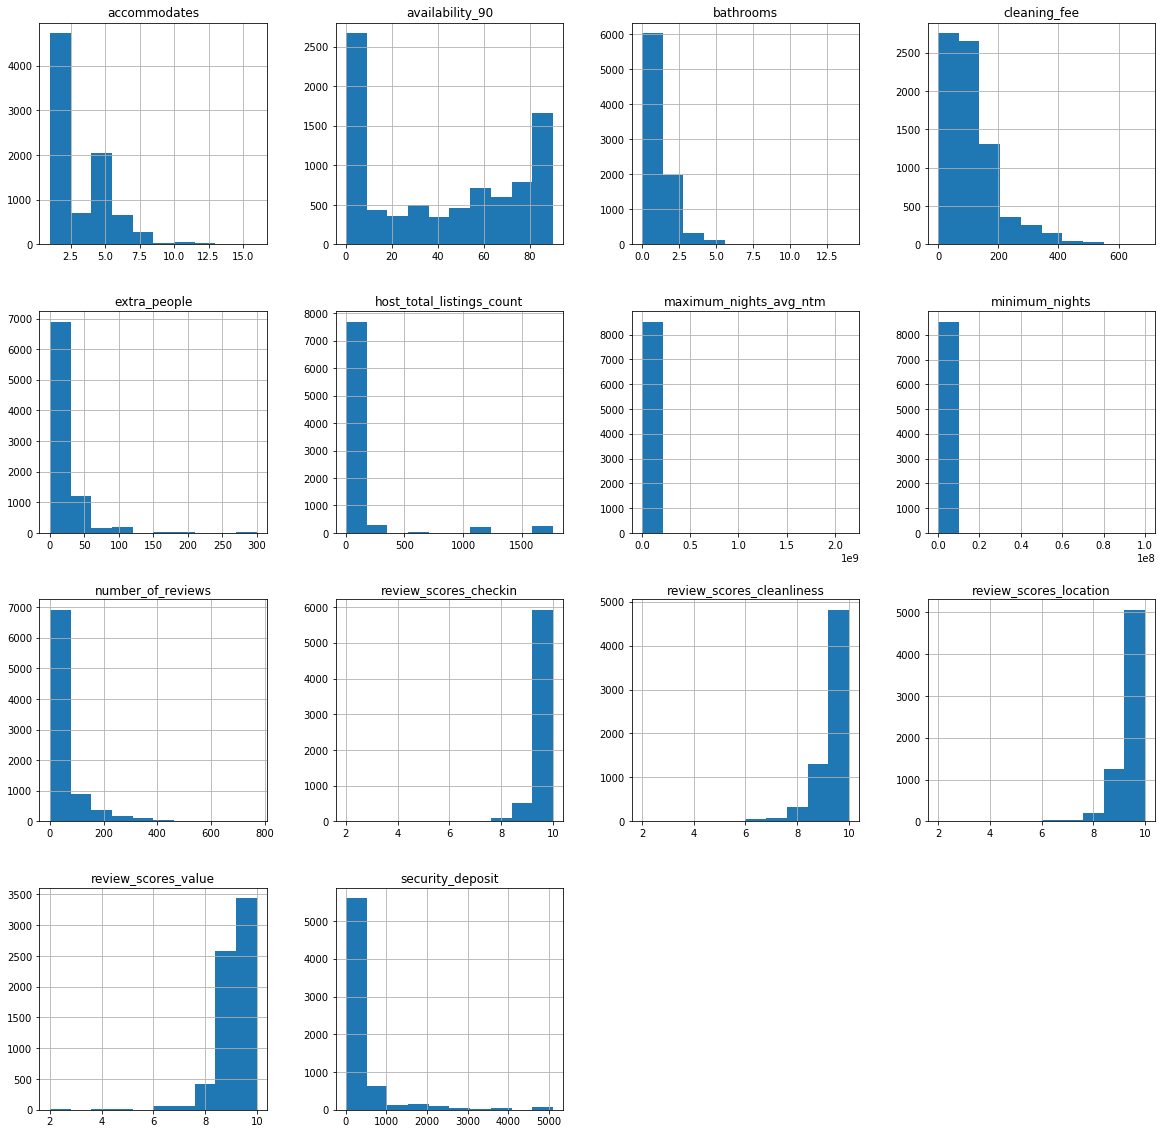

In [38]:
df.hist(figsize=(20,20));

In [39]:
print(df.shape)
[print(i) for i in df.columns];


(8533, 32)
host_since
price
host_response_time
host_response_rate
host_is_superhost
host_total_listings_count
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
zipcode
property_type
room_type
bathrooms
accommodates
bed_type
amenities
security_deposit
cleaning_fee
extra_people
minimum_nights
maximum_nights_avg_ntm
availability_90
number_of_reviews
first_review
last_review
review_scores_cleanliness
review_scores_checkin
review_scores_location
review_scores_value
instant_bookable
cancellation_policy


## Description of each column:
* host_since : date that the host first joined Airbnb
* price : nightly advertised price (the target variable)
* host_response_time : average amount of time the host takes to reply to messages
* host_response_rate : proportion of messages that the host replies to
* host_is_superhost : whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
* host_total_listings_count : how many listings the host has in total
* host_has_profile_pic :
* neighbourhood_cleansed:
* zipcode : zip code 
* property_type : type of property, e.g. house or flat
* room_type : type of listing, e.g. entire home, private room or shared room
* bathrooms : number of bathrooms
* accommodates : number of people hosts
* bed_type : type of bed, e.g. real bed or sofa-bed
* amenities : list of amenities
* security_deposit : the amount required as a security deposit
* cleaning_fee : the amount of the cleaning fee (a fixed amount paid per booking)
* extra_people : the price per additional guest above the guests_included price
* minimum_nights : the minimum length of stay
* maximum_nights_avg_ntm : the averaged maximum length of stay
* availability_90 : how many nights are available to be booked in the next 90 days
* number_of_reviews : the number of reviews left for the property
* first_review : the date of the first review
* last_review : the date of the most recent review
* review_scores_cleanliness : guests can score the accuracy of a property's description from 1 to 5 stars
* review_scores_checkin : guests can score their check-in from 1 to 5 stars
* review_scores_location : guests can score a property's location from 1 to 5 stars
* review_scores_value:
* instant_bookable : whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
* cancellation_policy : the type of cancellation policy, e.g. strict or moderate

# Part 3. Process each individual features

In [40]:
# a list holds columns to be deleted after pre-processing
tobedeleted_col=[]

## A. Hosting Features
    host_since
    host_response_time
    host_response_rate
    host_is_superhost
    host_total_listings_count
    host_has_profile_pic
    host_identity_verified

### - host_since
* This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (12/4/2019). 
* fill nan with mean
* The original column will be added to a list to be dropped later.

In [41]:
# print # (percentage) of missing values
pri_missing_perc('host_since')

 54 (0.6328372202039142%) missing values in host_since 


Mean days as host: 1784.0
Median days as host: 1835.0


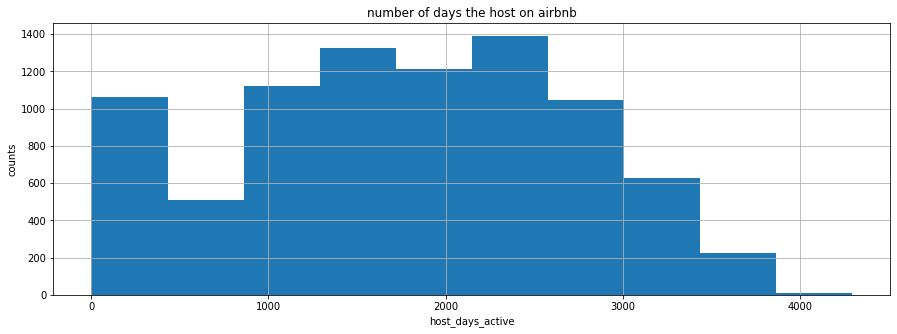

In [42]:
# convert to datetime
df['host_since'] = pd.to_datetime(df['host_since']) 

# Calculating the number of days
df['host_days_active'] = (date_last_scraped-df['host_since']).astype('timedelta64[D]')

# get median and mean
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# replacing NAN with mean
df['host_days_active'].fillna(df['host_days_active'].mean(), inplace=True)

hist_plot(df, 'host_days_active', 'number of days the host on airbnb')

tobedeleted_col.append(['host_since'])

### - host_response_time

In [43]:
# print # (percentage) of missing values
pri_missing_perc('host_response_time')

 1000 (11.719207781553967%) missing values in host_response_time 


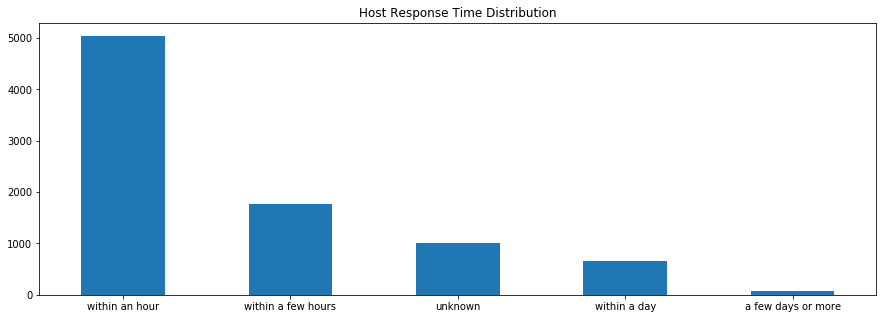

In [44]:
# fill them with unknown
df['host_response_time'].fillna('unknown', inplace=True)

# Category counts
df['host_response_time'].value_counts(normalize=True)

catogory_plot(df,'host_response_time', 'Host Response Time Distribution')

### - host_response_rate

In [45]:
# (percentage) of missing values
pri_missing_perc('host_response_rate')

 1000 (11.719207781553967%) missing values in host_response_rate 


#### a relatively large portion of missing values. fill with 'unknow'

Mean host response rate: 97.0
Median host response rate: 100.0


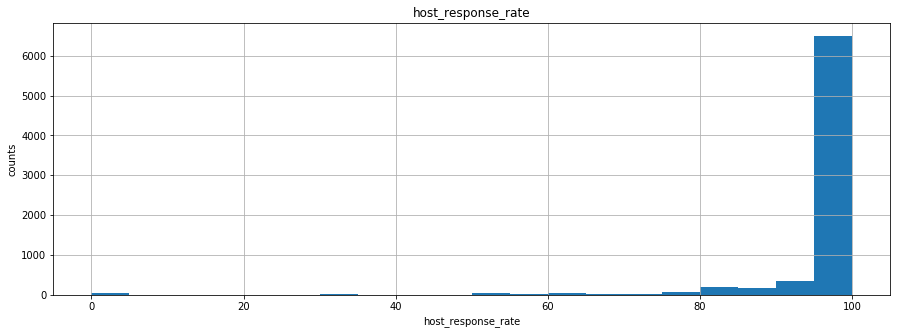

In [46]:
# convert percentage to a real number
df['host_response_rate']=df['host_response_rate'].str[:-1].astype('float64')
print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())

hist_plot(df, 'host_response_rate', 'host_response_rate', nbin=20)

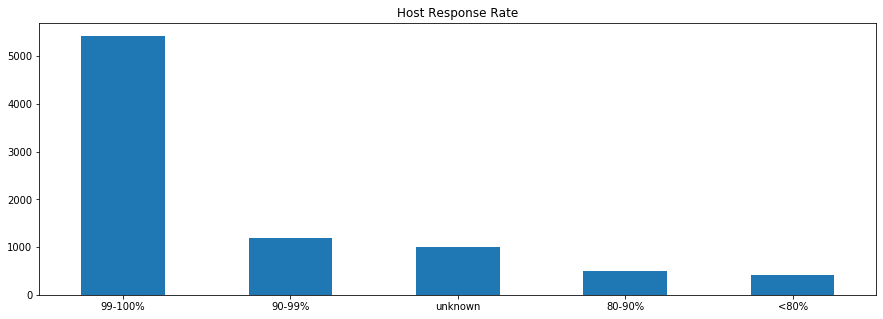

99-100%    0.635884
90-99%     0.140748
unknown    0.117192
80-90%     0.057776
<80%       0.048400
Name: host_response_rate, dtype: float64

In [47]:
# # convert the contineous variable into 4 bins and fill with unknown
into_bins('host_response_rate',bins=[0, 80, 90, 99, 100],
          labels=['<80%', '80-90%', '90-99%' ,'99-100%'], nan_label='unknown')

# Converting to string
df['host_response_rate'] = df['host_response_rate'].astype('str')

# Category counts
catogory_plot(df,'host_response_rate', 'Host Response Rate')
df['host_response_rate'].value_counts(normalize=True)


### - host_is_superhost

In [48]:
# print # (percentage) of missing values
pri_missing_perc('host_is_superhost')

 54 (0.6328372202039142%) missing values in host_is_superhost 


In [49]:
df['host_is_superhost'].replace({'f': 0, 't':1}, inplace=True)
df['host_is_superhost'].value_counts(normalize=True)

0.0    0.582144
1.0    0.417856
Name: host_is_superhost, dtype: float64

#### As percentage of 'f' and 't' are quite close, there is not a dominant mode. Considering the portion of missing values is small, those rows will be dropped.

In [50]:
print('dataset shape before dropping: {}'.format(df.shape))
df.dropna(subset=['host_is_superhost'], axis=0, inplace=True)
print('dataset shape after dropping: {}'.format(df.shape))

dataset shape before dropping: (8533, 33)
dataset shape after dropping: (8479, 33)


### - host_total_listings_count

In [51]:
# print # (percentage) of missing values
pri_missing_perc('host_total_listings_count')

 0 (0.0%) missing values in host_total_listings_count 


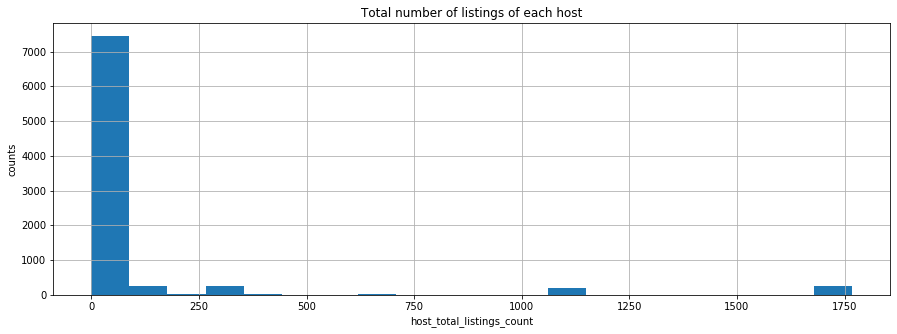

In [52]:
hist_plot(df, 'host_total_listings_count','Total number of listings of each host', nbin=20)

In [53]:
df[df['host_total_listings_count']>1500]['host_total_listings_count'].value_counts()

1768.0    254
Name: host_total_listings_count, dtype: int64

### - host_has_profile_pic

In [54]:
# print # (percentage) of missing values
pri_missing_perc('host_has_profile_pic')
df['host_has_profile_pic'].value_counts(normalize=True)

 0 (0.0%) missing values in host_has_profile_pic 


t    0.994929
f    0.005071
Name: host_has_profile_pic, dtype: float64

####  This feature is dominant by 't' (more than 99%). So this feature will be dropped as it does not provide much information.

In [55]:
tobedeleted_col.append(['host_has_profile_pic'])

### - host_identity_verified

In [56]:
# print # (percentage) of missing values
pri_missing_perc('host_identity_verified')
df['host_identity_verified'].value_counts(normalize=True)

 0 (0.0%) missing values in host_identity_verified 


t    0.505366
f    0.494634
Name: host_identity_verified, dtype: float64

In [57]:
df['host_identity_verified'].replace({'f': 0, 't': 1}, inplace=True)

## B. Location
    'neighbourhood', 
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed', 
    'zipcode' 

### study which feature to keep

In [58]:
pri_missing_perc('neighbourhood')
print(df['neighbourhood'].value_counts().shape)
df['neighbourhood'].value_counts(normalize=True)

 10 (0.11793843613633684%) missing values in neighbourhood 
(55,)


Mission District         0.092219
SoMa                     0.075334
Western Addition/NOPA    0.055024
Richmond District        0.051718
Outer Sunset             0.048294
Downtown                 0.046641
Bernal Heights           0.046523
Nob Hill                 0.045696
Noe Valley               0.042154
The Castro               0.041091
Haight-Ashbury           0.027630
Bayview                  0.026331
Potrero Hill             0.025387
Pacific Heights          0.021254
Tenderloin               0.021136
Inner Sunset             0.018656
Union Square             0.018656
Telegraph Hill           0.017712
Duboce Triangle          0.017357
Excelsior                0.015822
South Beach              0.014405
Cole Valley              0.014051
Sunnyside                0.013933
Russian Hill             0.012989
Hayes Valley             0.012516
Marina                   0.012162
Crocker Amazon           0.010981
Lower Haight             0.010273
Chinatown                0.009210
Financial Dist

In [59]:
pri_missing_perc('neighbourhood_cleansed')
print(df['neighbourhood_cleansed'].value_counts().shape)
df['neighbourhood_cleansed'].value_counts(normalize=True)

 0 (0.0%) missing values in neighbourhood_cleansed 
(37,)


Mission                  0.092582
Downtown/Civic Center    0.089161
South of Market          0.087982
Western Addition         0.074183
Castro/Upper Market      0.054959
Haight Ashbury           0.048473
Bernal Heights           0.048355
Noe Valley               0.039156
Nob Hill                 0.038212
Outer Sunset             0.037151
Potrero Hill             0.029367
Inner Richmond           0.026772
Bayview                  0.026654
Financial District       0.024177
Marina                   0.022408
North Beach              0.022290
Excelsior                0.022172
Russian Hill             0.022054
Outer Richmond           0.022054
Outer Mission            0.020757
Inner Sunset             0.020050
Pacific Heights          0.018870
Ocean View               0.016865
West of Twin Peaks       0.016865
Parkside                 0.016747
Chinatown                0.016393
Visitacion Valley        0.008963
Twin Peaks               0.008020
Glen Park                0.007784
Lakeshore     

In [60]:
pri_missing_perc('zipcode')
print(df['zipcode'].value_counts().shape)
df['zipcode'].value_counts(normalize=True)

 245 (2.8894916853402526%) missing values in zipcode 
(47,)


94110       0.121933
94117       0.084649
94109       0.080520
94114       0.080155
94103       0.063760
94102       0.056838
94112       0.048943
94122       0.044085
94107       0.042507
94108       0.035341
94115       0.034613
94131       0.034127
94133       0.032669
94118       0.027933
94121       0.027569
94116       0.026597
94124       0.026354
94123       0.025990
94134       0.018703
94127       0.017610
94105       0.014574
94132       0.010566
94158       0.008137
94111       0.006437
CA 94103    0.004615
94014       0.004494
CA 94109    0.003765
CA 94107    0.003401
CA 94105    0.003036
94104       0.002186
CA 94158    0.001943
CA 94102    0.001336
CA 94108    0.001214
CA 94115    0.000607
94015       0.000364
CA 94133    0.000364
CA 94117    0.000243
94130       0.000243
CA 94123    0.000243
CA 94110    0.000243
CA 94114    0.000243
CA 94131    0.000243
94080       0.000121
94113       0.000121
94510       0.000121
94129       0.000121
CA          0.000121
Name: zipcode

#### neighbourhood_cleansed has 0 missing values and least distinct values. It will be used in this study as the feature related to location. 

In [61]:
tobedeleted_col.append(['zipcode'])
tobedeleted_col.append(['neighbourhood'])

### - neighbourhood_cleansed 

 0 (0.0%) missing values in neighbourhood_cleansed 


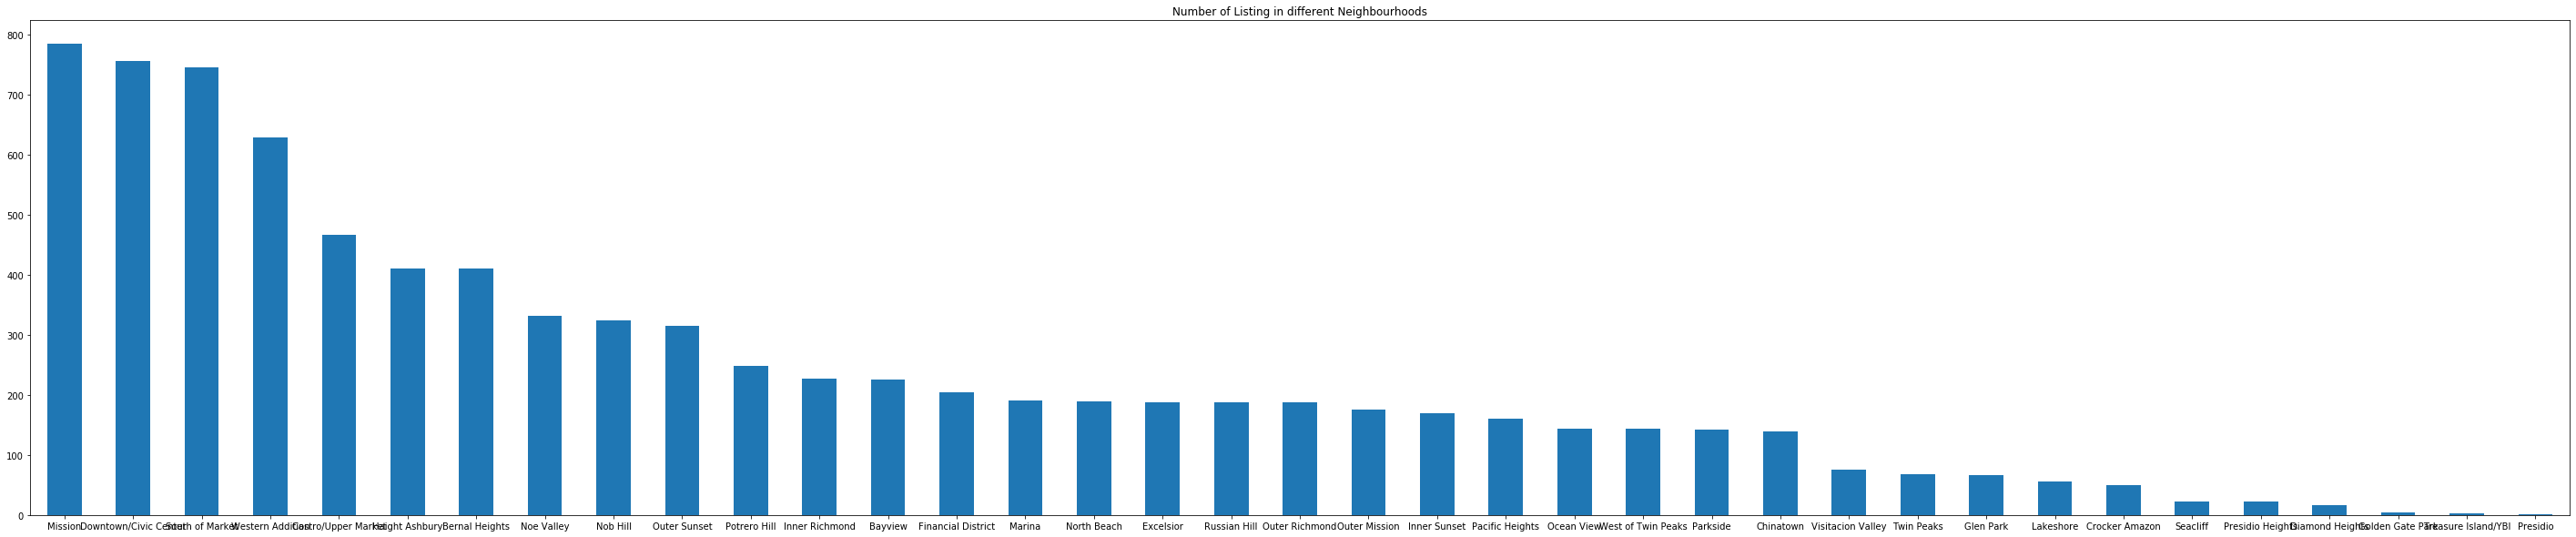

In [62]:
# print # (percentage) of missing 
pri_missing_perc('neighbourhood_cleansed')
catogory_plot(df, 'neighbourhood_cleansed','Number of Listing in different Neighbourhoods', (50,10))

## C. Property type related
    property_type
    room_type
    accommodates
    bathrooms
    bed_type
    amenities

### - property_type

replacing not working so far

In [63]:
# print # (percentage) of missing values
pri_missing_perc('property_type')
df['property_type'].value_counts(normalize=True)

 0 (0.0%) missing values in property_type 


Apartment             0.405472
House                 0.278453
Condominium           0.106263
Guest suite           0.069466
Boutique hotel        0.039863
Hotel                 0.017101
Townhouse             0.016747
Loft                  0.015568
Serviced apartment    0.012973
Hostel                0.009081
Aparthotel            0.007784
Guesthouse            0.005307
Bed and breakfast     0.003892
Other                 0.002713
Resort                0.002123
Cottage               0.002005
Bungalow              0.001769
Castle                0.000708
Villa                 0.000708
Boat                  0.000354
Cabin                 0.000354
Tiny house            0.000354
Camper/RV             0.000236
Earth house           0.000236
In-law                0.000236
Dome house            0.000118
Hut                   0.000118
Name: property_type, dtype: float64

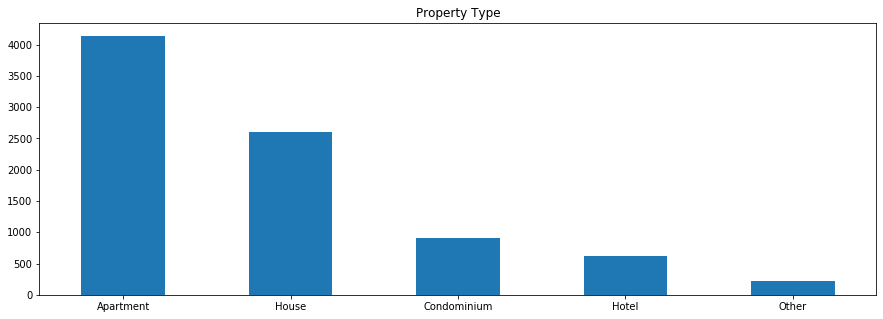

Apartment      0.487911
House          0.305932
Condominium    0.106263
Hotel          0.073829
Other          0.026064
Name: property_type, dtype: float64

In [64]:
# replace with less types
df['property_type'].replace({'Serviced apartment': 'Apartment',
                             'Boutique hotel': 'Hotel',
                             'Aparthotel': 'Hotel',
                             'Hostel': 'Hotel',
                             'Guesthouse': 'House',
                             'Cabin': 'House',
                             'Resort': 'Other',
                             'Cottage': 'House',
                             'Villa': 'House',
                             'Chalet': 'House',
                             'Tiny house':'House',
                             'Earth house':'House',
                             'Cycladic house (Greece)':'House',
                             'In-law': 'Other',
                             'Bed and breakfast': 'Other',
                             'Farm stay': 'Other',
                             'Hut': 'Other',
                             'Castle':'Other',
                             'Boat': 'Other',
                             'Bungalow': 'House',
                             'Guest suite': 'Apartment',
                             'Townhouse': 'House',
                             'Camper/RV': 'Other',
                             'Dome house': 'Other',
                             'Loft':'Other'
                            }, inplace=True)

#  staticstics and visualization
catogory_plot(df, 'property_type', 'Property Type')
df['property_type'].value_counts(normalize=True)

## - room_type

In [65]:
# print # (percentage) of missing values
pri_missing_perc('room_type')

 0 (0.0%) missing values in room_type 


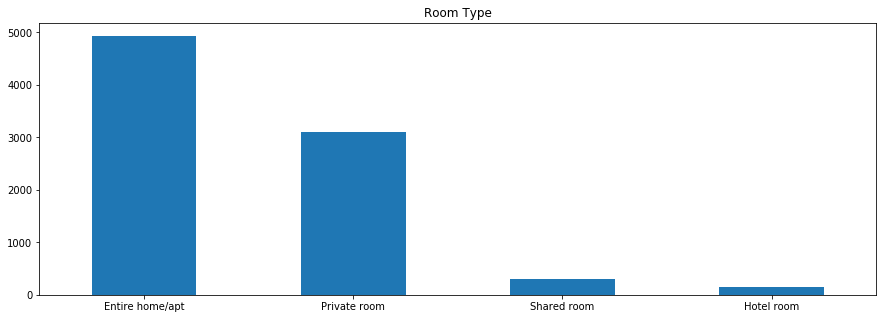

Entire home/apt    0.581672
Private room       0.365609
Shared room        0.034556
Hotel room         0.018163
Name: room_type, dtype: float64

In [66]:
catogory_plot(df, 'room_type', 'Room Type')
df['room_type'].value_counts(normalize=True)

## - accommodates

In [67]:
# print # (percentage) of missing values
pri_missing_perc('accommodates')

 0 (0.0%) missing values in accommodates 


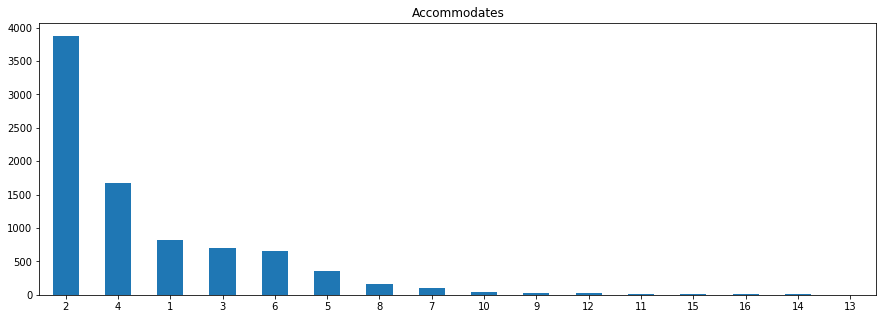

2     3875
4     1670
1      821
3      702
6      656
5      357
8      168
7      105
10      48
9       24
12      23
11      10
15       7
16       7
14       5
13       1
Name: accommodates, dtype: int64

In [68]:
catogory_plot(df, 'accommodates', 'Accommodates')
df['accommodates'].value_counts()

## - bathrooms

In [69]:
# print # (percentage) of missing values
pri_missing_perc('bathrooms')

 5 (0.05896921806816842%) missing values in bathrooms 


In [70]:
print('Median of number of bathrooms: {}'.format(df['bathrooms'].median()))
print('Mean of number of bathrooms: {}'.format(df['bathrooms'].mean()))
df['bathrooms'].value_counts()

Median of number of bathrooms: 1.0
Mean of number of bathrooms: 1.404708520179372


1.0     5941
2.0     1154
1.5      588
2.5      238
3.0      170
5.0      122
4.0       82
3.5       67
0.0       27
10.0      23
0.5       21
4.5       15
8.0        9
6.0        9
7.0        5
14.0       1
6.5        1
5.5        1
Name: bathrooms, dtype: int64

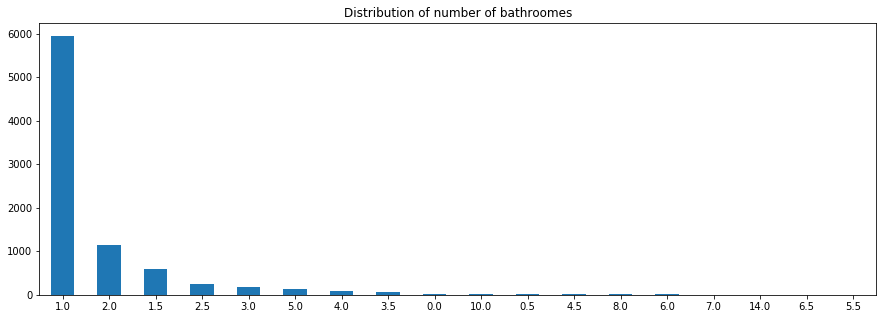

In [71]:
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
catogory_plot(df, 'bathrooms', 'Distribution of number of bathroomes')


## - bed_type

In [72]:
# print # (percentage) of missing values
pri_missing_perc('bed_type')

 0 (0.0%) missing values in bed_type 


In [73]:
df['bed_type'].value_counts(normalize=True)

Real Bed         0.991744
Futon            0.003774
Pull-out Sofa    0.002241
Airbed           0.001415
Couch            0.000826
Name: bed_type, dtype: float64

#### more than 99% instances have the same value --> drop 

In [74]:
tobedeleted_col.append(['bed_type'])

## - amenities

In [75]:
# print # (percentage) of missing values
pri_missing_perc('amenities')

 0 (0.0%) missing values in amenities 


In [76]:
# get a set of amenities
amenities_list_string=" ".join(list(df['amenities']))
amenities_list_string=amenities_list_string.replace('{','')
amenities_list_string=amenities_list_string.replace('}',',')
amenities_list_string=amenities_list_string.replace('"','')

amenities_set=set([x.strip() for x in amenities_list_string.split(',')])
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'En suite bathroom',
 'Espresso machine

In [77]:
play=df.amenities[:1]
print(play)
play.str.contains('24-hour check-in|Self check-in')

0    {TV,"Cable TV",Internet,Wifi,Kitchen,"Pets liv...
Name: amenities, dtype: object


0    True
Name: amenities, dtype: bool

In [78]:
# creat new columns for selected importand amentites
# droped: 'Buzzer/Wireless Intercom', 'Doorman','Essentials','Fire Extinguisher','First Aid Kit'
# 'Hair Dryer','Hangers','Hot Tub', 'Indoor Fireplace','Iron','Laptop Friendly Workspace','Lock on Bedroom Door',
# 'Safety Card','Shampoo'

df.loc[df['amenities'].str.contains('24-hour check-in|Self check-in', case=False), 'easy_check_in'] = 1
df.loc[df['amenities'].str.contains('Central air conditioning', case=False), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Breakfast', case=False), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('Cable TV|Smart TV|TV', case=False), 'TV'] = 1
df.loc[df['amenities'].str.contains('Cat(s)|Dog(s)|Other pet(s)|Pets allowed|Pets live on this property', case=False), 'pets'] = 1
df.loc[df['amenities'].str.contains('Elevator', case=False), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Free parking on premises|Free street parking', case=False), 'free_parking'] = 1
df.loc[df['amenities'].str.contains('Gym|Exercise equipment', case=False), 'gym'] = 1
df.loc[df['amenities'].str.contains('Heating', case=False), 'heating'] = 1
df.loc[df['amenities'].str.contains('Wifi|Internet|Ethernet connection', case=False), 'internet'] = 1
df.loc[df['amenities'].str.contains('Refrigerator|Full kitchen|Stove|Steam oven|Outdoor kitchen|Kitchen|Oven|Mini fridge|Microwave|Kitchenette|Gas oven|Baking sheet|Bread maker|Double oven|Barbecue utensils|BBQ grill|Convection oven|Dishwasher|Dishes and silverware|Cooking basics', case=False), 'cooking'] = 1
df.loc[df['amenities'].str.contains('Pool', case=False), 'pool'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed', case=False), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Suitable for events', case=False), 'suitable_events'] = 1
df.loc[df['amenities'].str.contains('Wheelchair accessible |Accessible-height bed| Accessible-height bed|Disabled parking spot', case=False), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Washer|Dryer|Washer/Dryer', case=False), 'laundary'] = 1
df.loc[df['amenities'].str.contains('Baby bath|Baby monitor|Babysitter recommendations|Changing table|Crib|Children’s books and toys|Children’s dinnerware|Family/kid friendly', case=False), 'family_kid_friendly'] = 1
df.loc[df['amenities'].str.contains('Beach essentials|Beach view|Beachfront', case=False), 'beach'] = 1
df.loc[df['amenities'].str.contains('EV charger', case=False), 'ev_charger'] = 1
df.loc[df['amenities'].str.contains('Garden or backyard|Courtyard|Balcony|Patio or balcony|Terrace', case=False), 'yard'] = 1
df.loc[df['amenities'].str.contains('Netflix|Apple TV|HBO GO|Nest thermometer|Smart home technology|Smart lock', case=False), 'smart_home'] = 1
df.loc[df['amenities'].str.contains('Smoke detector', case=False), 'smoke_detector'] = 1
df.loc[df['amenities'].str.contains('Carbon monoxide detector', case=False), 'carbon_monoxide_detect'] = 1

# new columns are:
new_col=['easy_check_in','air_conditioning','breakfast','TV','carbon_monoxide_detect',
         'pets','elevator','family_kid_friendly','free_parking','gym','heating','internet',
         'cooking','pool','smoke_detector','smoking_allowed','suitable_events','accessible','laundary',
         'beach', 'ev_charger', 'yard','smart_home']


tobedeleted_col.append(['amenities'])
for col in new_col:
    df[col]= df[col].fillna(0)
    print(col)
    print(df[col].value_counts())

    if (df[col].value_counts().shape[0] == 1):
        tobedeleted_col.append([col])
    if (df[col].value_counts().shape[0] == 2) :
        if ((df[col].value_counts()[0]/df[col].value_counts()[1]<(1.0/10) ) or  (df[col].value_counts()[0]/df[col].value_counts()[1]>10 )):
            tobedeleted_col.append([col])

tobedeleted_col

# easy_check_in, pets, free_parking, internet, beach, yard
# these columns seem fail to work. 

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


easy_check_in
1.0    4803
0.0    3676
Name: easy_check_in, dtype: int64
air_conditioning
0.0    8476
1.0       3
Name: air_conditioning, dtype: int64
breakfast
0.0    7573
1.0     906
Name: breakfast, dtype: int64
TV
1.0    6864
0.0    1615
Name: TV, dtype: int64
carbon_monoxide_detect
1.0    7188
0.0    1291
Name: carbon_monoxide_detect, dtype: int64
pets
0.0    6718
1.0    1761
Name: pets, dtype: int64
elevator
0.0    6779
1.0    1700
Name: elevator, dtype: int64
family_kid_friendly
0.0    5432
1.0    3047
Name: family_kid_friendly, dtype: int64
free_parking
1.0    4266
0.0    4213
Name: free_parking, dtype: int64
gym
0.0    7348
1.0    1131
Name: gym, dtype: int64
heating
1.0    8013
0.0     466
Name: heating, dtype: int64
internet
1.0    8354
0.0     125
Name: internet, dtype: int64
cooking
1.0    7719
0.0     760
Name: cooking, dtype: int64
pool
0.0    8283
1.0     196
Name: pool, dtype: int64
smoke_detector
1.0    7988
0.0     491
Name: smoke_detector, dtype: int64
smoking_allowe

[['host_since'],
 ['host_has_profile_pic'],
 ['zipcode'],
 ['neighbourhood'],
 ['bed_type'],
 ['amenities'],
 ['air_conditioning'],
 ['heating'],
 ['internet'],
 ['cooking'],
 ['pool'],
 ['smoke_detector'],
 ['smoking_allowed'],
 ['suitable_events'],
 ['accessible'],
 ['laundary'],
 ['beach'],
 ['ev_charger'],
 ['smart_home']]

# C.  other relevant features
    security_deposit
    cleaning_fee
    extra_people
    instant_bookable
    cancellation_policy

## - security_deposit

In [79]:
# print # (percentage) of missing values
pri_missing_perc('security_deposit')

 1745 (20.58025710579078%) missing values in security_deposit 


#### missing value would be interpreted as a security deposit of 0.

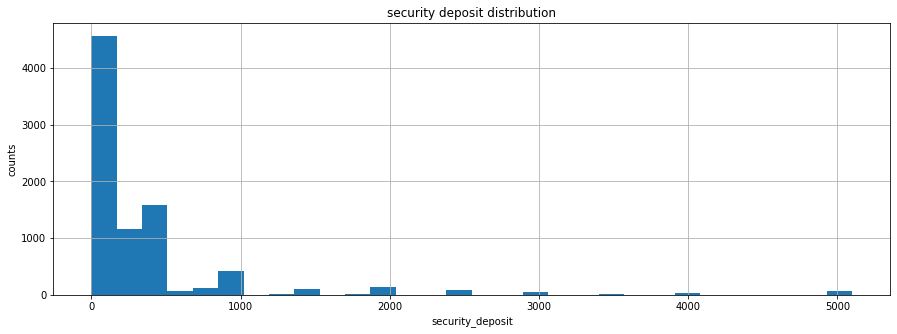

In [80]:
df['security_deposit'].fillna(0, inplace=True)
df['security_deposit']=df['security_deposit'].astype('float')
hist_plot(df, 'security_deposit', 'security deposit distribution',nbin=30)

## - cleaning_fee

In [81]:
# print # (percentage) of missing values
pri_missing_perc('cleaning_fee')

 948 (11.180563745724733%) missing values in cleaning_fee 


#### missing value would be interpreted as a cleaning fee of 0.

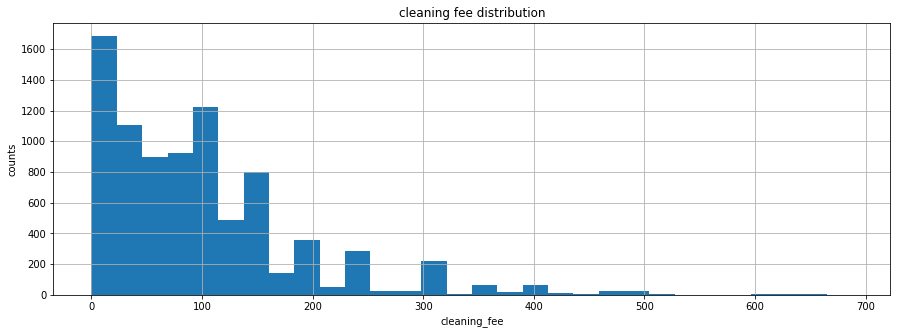

In [82]:
df['cleaning_fee'].fillna(0, inplace=True)
df['cleaning_fee']=df['cleaning_fee'].astype('float')
hist_plot(df, 'cleaning_fee', 'cleaning fee distribution', nbin=30)

## - extra_people

In [83]:
# print # (percentage) of missing values
pri_missing_perc('extra_people')

 0 (0.0%) missing values in extra_people 


missing value would be interpreted as 0

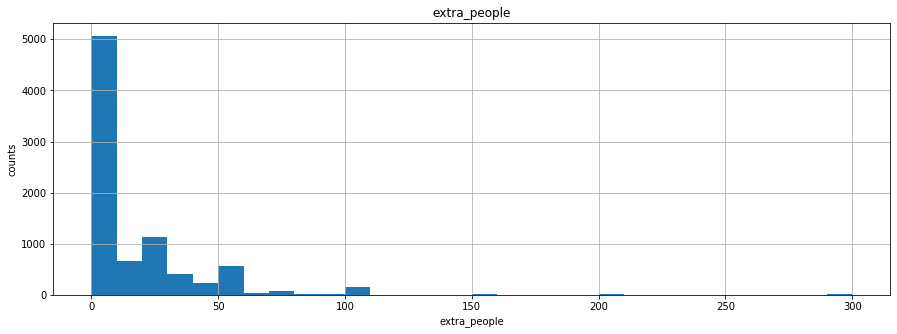

In [84]:
df['extra_people'].fillna(0,inplace=True)
df['extra_people']=df['extra_people'].astype('float')
hist_plot(df, 'extra_people', 'extra_people', nbin=30)

## - instant_bookable

In [85]:
# print # (percentage) of missing values
pri_missing_perc('instant_bookable')

 0 (0.0%) missing values in instant_bookable 


In [86]:
df['instant_bookable'].replace({'f': 0 , 't': 1}, inplace=True)
df['instant_bookable'].value_counts(normalize=True)

0    0.578488
1    0.421512
Name: instant_bookable, dtype: float64

## - cancellation_policy

In [87]:
# print # (percentage) of missing values
pri_missing_perc('cancellation_policy')

 0 (0.0%) missing values in cancellation_policy 


In [88]:
# hist_plot(df, 'cancellation_policy', 'Cancellation Policy', nbin=30)

df['cancellation_policy'].value_counts(normalize=True)

strict_14_with_grace_period    0.441797
moderate                       0.315957
flexible                       0.221253
strict                         0.013209
super_strict_30                0.005543
super_strict_60                0.002241
Name: cancellation_policy, dtype: float64

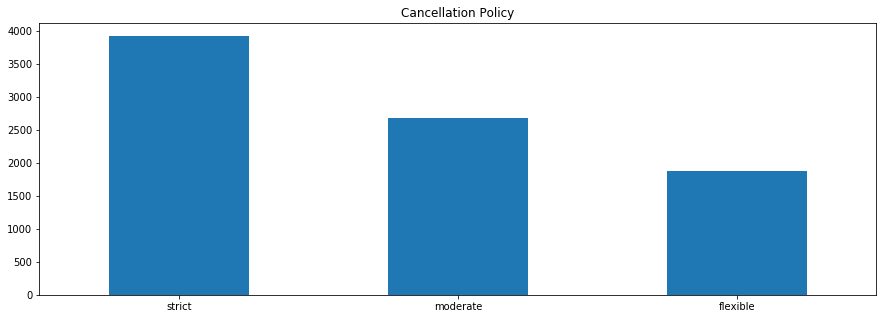

strict      0.462790
moderate    0.315957
flexible    0.221253
Name: cancellation_policy, dtype: float64

In [89]:
# combines super_strict_30, siper_strick_60 and strict to "strict"
df['cancellation_policy'].replace({'super_strict_30':'strict', 
                                   'super_strict_60':'strict',
                                  'strict_14_with_grace_period':'strict'},inplace=True)

catogory_plot(df, 'cancellation_policy', 'Cancellation Policy')
df['cancellation_policy'].value_counts(normalize=True)

# D. Availablility
    availability_90
    minimum_nights
    maximum_nights_avg_ntm

## - availability_90

In [90]:
# print # (percentage) of missing values
pri_missing_perc('availability_90')

 0 (0.0%) missing values in availability_90 


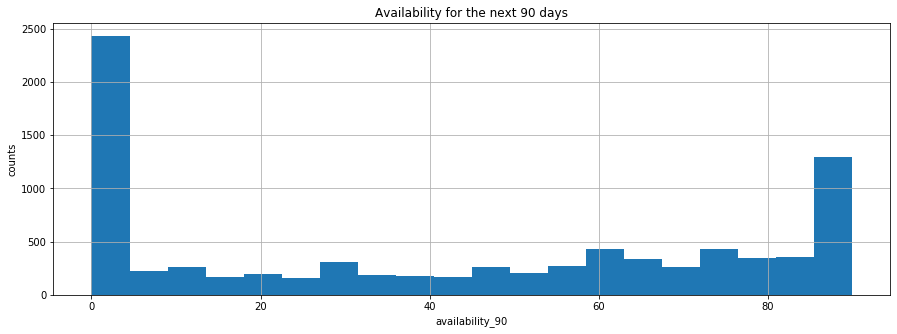

In [91]:
hist_plot(df, 'availability_90', 'Availability for the next 90 days', nbin=20)

## - minimum_nights 

In [92]:
# print # (percentage) of missing values
pri_missing_perc('minimum_nights')
df['minimum_nights'].value_counts(normalize=True)

 0 (0.0%) missing values in minimum_nights 


30           0.410426
2            0.194363
1            0.174549
3            0.107560
4            0.037622
5            0.020521
31           0.014506
7            0.009317
32           0.006133
60           0.004953
90           0.003892
6            0.003656
180          0.002241
365          0.001061
14           0.000944
10           0.000944
29           0.000472
13           0.000472
120          0.000472
28           0.000472
45           0.000354
183          0.000354
50           0.000236
360          0.000236
58           0.000236
80           0.000236
40           0.000236
75           0.000236
8            0.000236
21           0.000236
85           0.000236
20           0.000118
9            0.000118
16           0.000118
55           0.000118
15           0.000118
150          0.000118
110          0.000118
200          0.000118
54           0.000118
1000         0.000118
38           0.000118
25           0.000118
100          0.000118
65           0.000118
1125      

#### Notice that there are three samples with minimum stay of 1 year. I consider them as outliers and will  not consider them in this study. 

In [93]:
df['minimum_nights'].describe()

count    8.479000e+03
mean     1.181029e+04
std      1.085994e+06
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      3.000000e+01
max      1.000000e+08
Name: minimum_nights, dtype: float64

In [94]:
df[df['minimum_nights']>200]['minimum_nights'].value_counts()

365          9
360          2
359          1
1125         1
1000         1
100000000    1
Name: minimum_nights, dtype: int64

#### maximum_nights_avg_ntm

In [95]:
# print # (percentage) of missing values
pri_missing_perc('maximum_nights_avg_ntm')
df['maximum_nights_avg_ntm'].describe()

 0 (0.0%) missing values in maximum_nights_avg_ntm 


count    8.479000e+03
mean     1.025423e+06
std      4.664724e+07
min      1.000000e+00
25%      2.900000e+01
50%      3.559000e+02
75%      1.125000e+03
max      2.147484e+09
Name: maximum_nights_avg_ntm, dtype: float64

#### notice that there are several rows with averaged max stay around 550000 years. They are considered as outliers and deleted below. 

In [96]:
df.drop(df.loc[df['maximum_nights_avg_ntm']>1000000].index, inplace = True)
df['maximum_nights_avg_ntm'].describe()

count      8474.000000
mean        546.377803
std        1214.768200
min           1.000000
25%          29.000000
50%         351.700000
75%        1125.000000
max      100000.000000
Name: maximum_nights_avg_ntm, dtype: float64

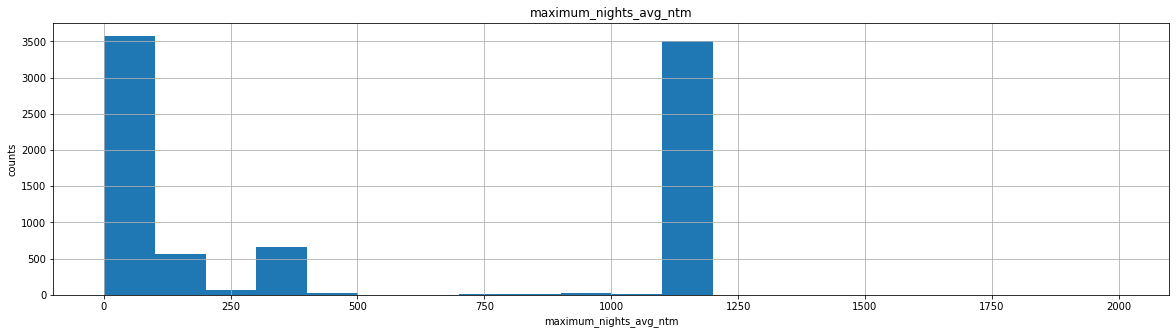

In [97]:
# plot the first 75% of the data
plt.figure(figsize=(20,5))
df[df['maximum_nights_avg_ntm']<=2000.0]['maximum_nights_avg_ntm'].hist(bins=20)
plt.xlabel('maximum_nights_avg_ntm')
plt.ylabel('counts')
plt.title('maximum_nights_avg_ntm')
plt.show()

# E. Reviews
    first_review
    last_review
    number_of_reviews 
    review_scores_cleanliness
    review_scores_checkin
    review_scores_location
    review_scores_value

## - first_review & last_review

In [98]:
# print # (percentage) of missing values
firstlastreview=['first_review','last_review']
for i in firstlastreview:
    pri_missing_perc(i)


 1882 (22.209110219494928%) missing values in first_review 
 1882 (22.209110219494928%) missing values in last_review 


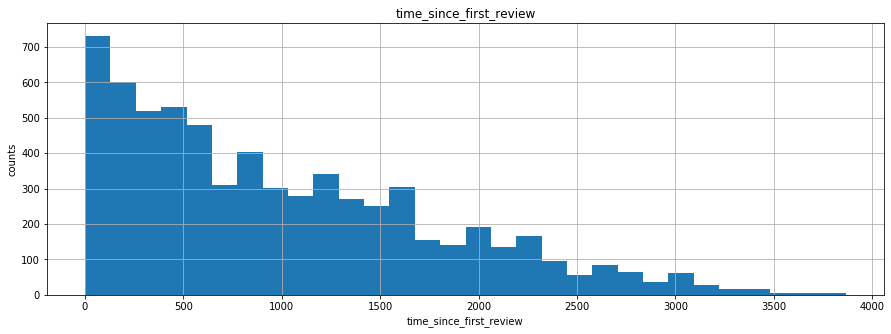

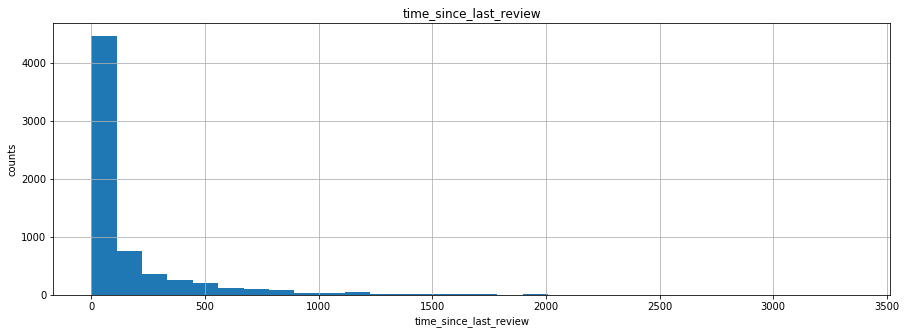

In [99]:
for i in firstlastreview:
    df[i]=pd.to_datetime(df[i])
    newcol='time_since_'+i
    df[newcol] = (date_last_scraped - df[i]).astype('timedelta64[D]')
    hist_plot(df, newcol, newcol, nbin=30)
    tobedeleted_col.append([i])


#### percentage of missing values is too large to simply replace with median or mean. will keep as unknown.

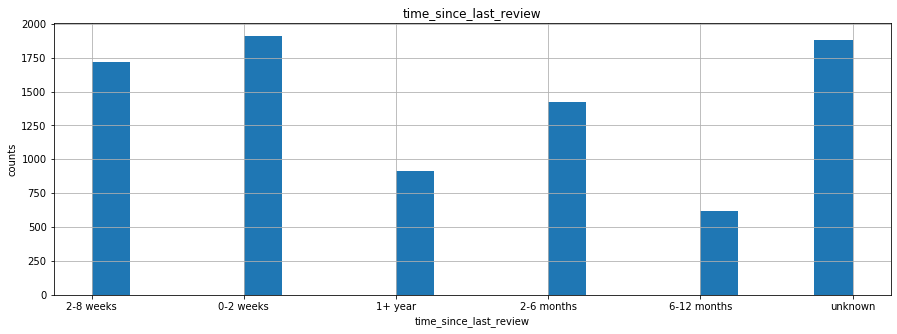

In [100]:
# organize those number into several bins, and make nan a seperate value
into_bins('time_since_last_review', bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
          labels=['0-2 weeks','2-8 weeks','2-6 months','6-12 months','1+ year'], nan_label='unknown')

hist_plot(df, 'time_since_last_review', 'time_since_last_review', nbin=20)

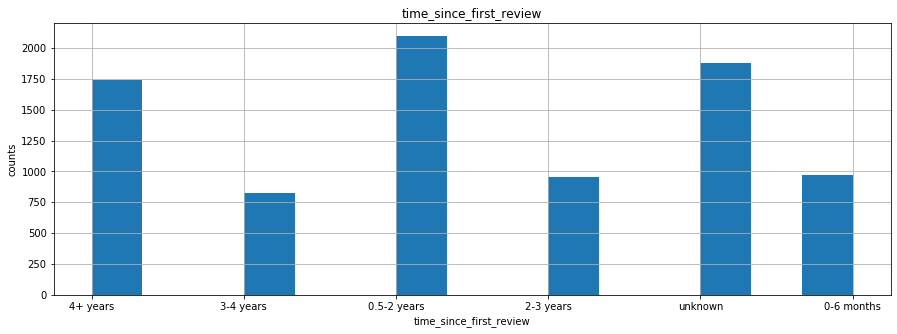

In [101]:
# organize those number into several bins, and make nan a seperate value
into_bins('time_since_first_review', bins=[0, 182, 730, 1095, 1460,  max(df.time_since_first_review)],
          labels=['0-6 months', '0.5-2 years','2-3 years', '3-4 years','4+ years'], nan_label='unknown')

hist_plot(df, 'time_since_first_review', 'time_since_first_review', nbin=15)

## - number_of_reviews

In [102]:
# print # (percentage) of missing values
pri_missing_perc('number_of_reviews')

 0 (0.0%) missing values in number_of_reviews 


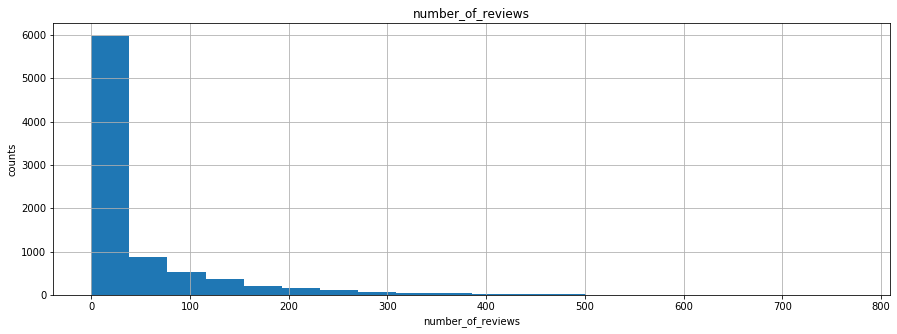

count    8474.000000
mean       44.772363
std        79.585574
min         0.000000
25%         1.000000
50%         9.000000
75%        52.000000
max       771.000000
Name: number_of_reviews, dtype: float64

In [103]:
hist_plot(df, 'number_of_reviews', 'number_of_reviews', nbin=20)
df['number_of_reviews'].describe()

## - other review matric
    review_scores_cleanliness
    review_scores_checkin
    review_scores_location
    review_scores_value

In [104]:
review_col=['review_scores_value', 'review_scores_checkin', 'review_scores_location','review_scores_cleanliness']
for col in review_col:
    pri_missing_perc(col)

 1929 (22.76374793485957%) missing values in review_scores_value 
 1929 (22.76374793485957%) missing values in review_scores_checkin 
 1929 (22.76374793485957%) missing values in review_scores_location 
 1928 (22.751947132405004%) missing values in review_scores_cleanliness 


In [105]:
for col in review_col:
    into_bins(col,bins=[0, 8, 9, 10],
          labels=['0-8', '9', '10' ], nan_label='unknown')

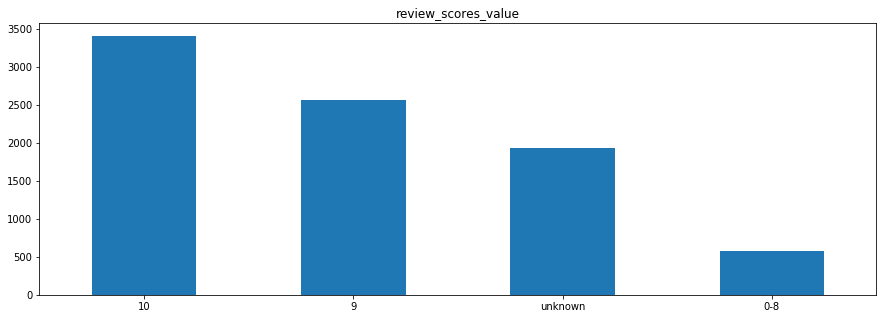

10         0.401817
9          0.302691
unknown    0.227637
0-8        0.067855
Name: review_scores_value, dtype: float64

In [106]:
catogory_plot(df, 'review_scores_value', 'review_scores_value')
df['review_scores_value'].value_counts(normalize=True)

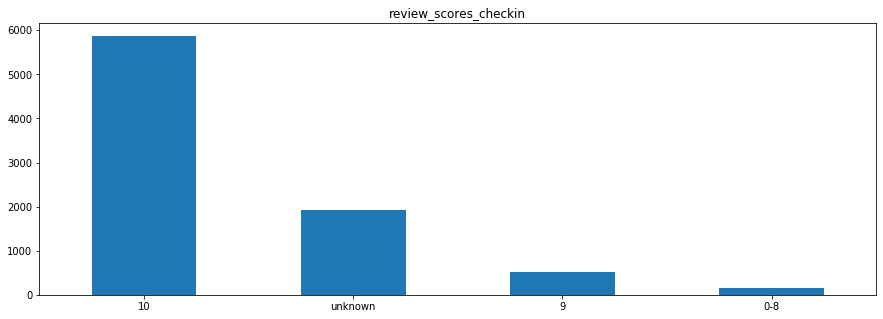

10         0.692825
unknown    0.227637
9          0.061836
0-8        0.017701
Name: review_scores_checkin, dtype: float64

In [107]:
catogory_plot(df, 'review_scores_checkin', 'review_scores_checkin')
df['review_scores_checkin'].value_counts(normalize=True)

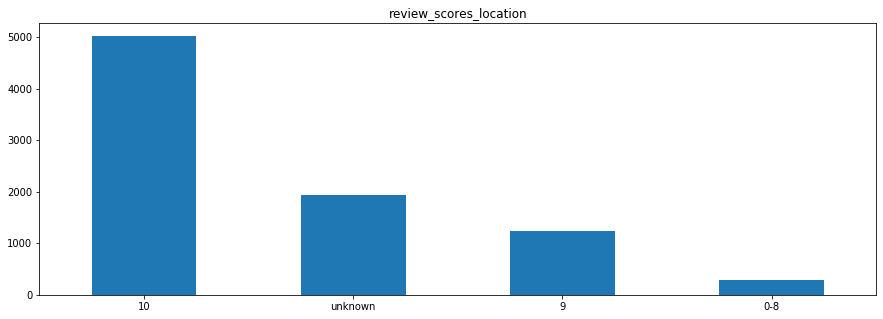

10         0.592400
unknown    0.227637
9          0.145622
0-8        0.034340
Name: review_scores_location, dtype: float64

In [108]:
catogory_plot(df, 'review_scores_location', 'review_scores_location')
df['review_scores_location'].value_counts(normalize=True)

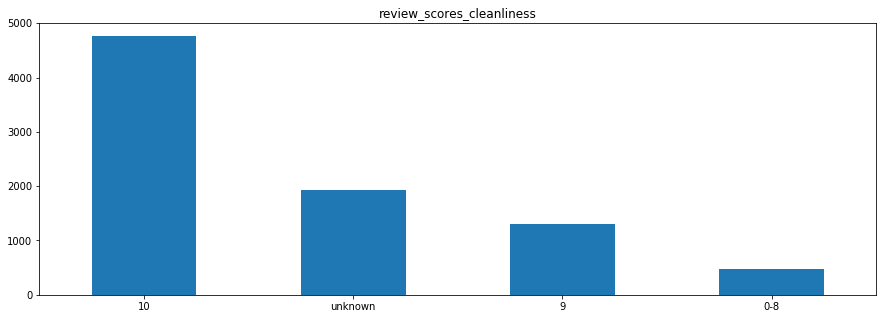

10         0.562308
unknown    0.227519
9          0.154473
0-8        0.055700
Name: review_scores_cleanliness, dtype: float64

In [109]:
catogory_plot(df, 'review_scores_cleanliness', 'review_scores_cleanliness')
df['review_scores_cleanliness'].value_counts(normalize=True)

# F. Target - Price

Minimum Listing Price is 0.0
Maximum Listing Price is 10000.0


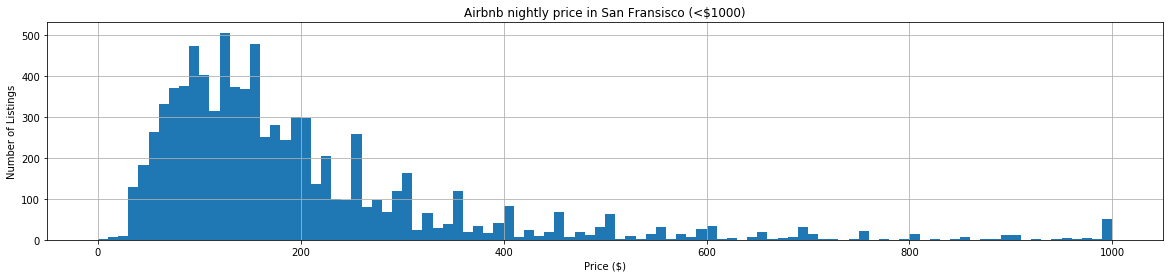

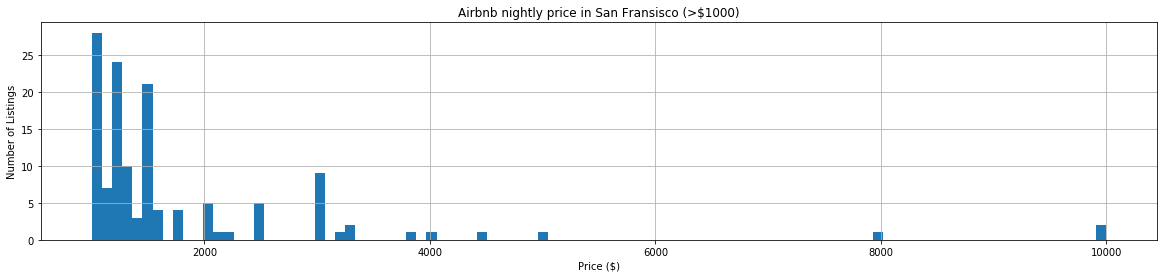

In [110]:
# target feature --> price

# string into number
df['price']=df['price'].str[1:].str.replace(',', '').astype('float64')

print('Minimum Listing Price is {}'.format(min(df['price'])))
print('Maximum Listing Price is {}'.format(max(df['price'])))

plt.figure(figsize=(20,4))
df['price'].hist(bins=100,range=(min(df['price']),1000))
plt.title('Airbnb nightly price in San Fransisco (<$1000)')     
plt.xlabel('Price ($)')
plt.ylabel('Number of Listings')
plt.savefig('Price_1.png')
plt.show()


plt.figure(figsize=(20,4))
df['price'].hist(bins=100,range=( 1000, max(df['price']) ))
plt.title('Airbnb nightly price in San Fransisco (>$1000)')     
plt.xlabel('Price ($)')
plt.ylabel('Number of Listings')
plt.savefig('Price_2.png')
plt.show()

In [111]:
df[df['price']>4000]['price'].value_counts()

5000.0     1
4500.0     1
8000.0     1
10000.0    1
9999.0     1
Name: price, dtype: int64

In [112]:
df[df['price']<10]['price'].value_counts()

0.0    2
Name: price, dtype: int64

In [113]:
df.drop(df.loc[df['price']>4000].index, inplace=True)
df.drop(df.loc[df['price']<10].index, inplace=True)


 mu = 5.07 and sigma = 0.71



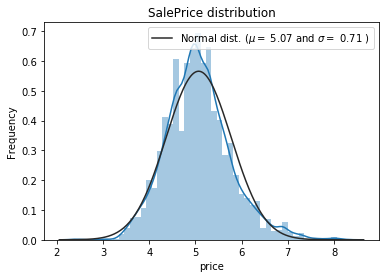

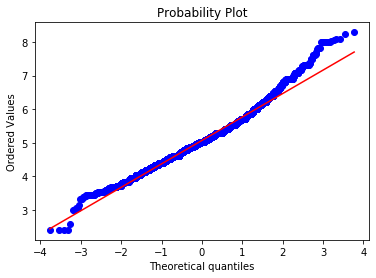

In [114]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["price"] = np.log1p(df["price"])

#Check the new distribution 
sns.distplot(df["price"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df["price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df["price"], plot=plt)
plt.show()

# more cleaning -  outliers

In [115]:
# cols=['price','host_total_listings_count', 'bathrooms', 'accommodates', 'security_deposit', 'cleaning_fee',
#       'extra_people', 'minimum_nights', 'maximum_nights_avg_ntm','availability_90','number_of_reviews',
#       'time_since_first_review','time_since_last_review']
# sns.pairplot(df[cols])

In [116]:
df.drop(df.loc[df['bathrooms']>10].index, inplace=True)
df.drop(df.loc[df['minimum_nights']>200].index, inplace=True)
df.drop(df.loc[df['maximum_nights_avg_ntm']>2000].index, inplace=True)

# Part 3 - More Analysis & Visualization

### - Which areas of San Francisco have the most Airbnb listings, and which area are the most expensive ones?

In [117]:
# import the map
df_map=gpd.read_file('SF/neighbourhoods.geojson')
df_map.drop('neighbourhood_group', axis=1, inplace=True)
df_map=df_map.set_index('neighbourhood')
df_map.head()

,geometry
neighbourhood,
Seacliff,"MULTIPOLYGON (((-122.48409 37.78791, -122.4843..."
Haight Ashbury,"MULTIPOLYGON (((-122.43596 37.76904, -122.4368..."
Outer Mission,"MULTIPOLYGON (((-122.45428 37.70822, -122.4545..."
Downtown/Civic Center,"MULTIPOLYGON (((-122.40891 37.79013, -122.4088..."
Diamond Heights,"MULTIPOLYGON (((-122.43553 37.74146, -122.4356..."


In [118]:
# df_neighbor holds mean/median prices, number of listings
df_neighbor=pd.DataFrame(df.groupby('neighbourhood_cleansed').size(), columns={'num_of_listings'})
df_neighbor['median_price']=df.groupby('neighbourhood_cleansed')['price'].median().values
df_neighbor['mean_price']=df.groupby('neighbourhood_cleansed')['price'].mean().values

# join the two
df_neighbor_map=df_map.join(df_neighbor)
df_neighbor_map.head()

print('Among all neighbourhoods: ')
print('\n- max of num_of_listings: {}'.format(max(df_neighbor_map['num_of_listings'])))
print('\n- max of median_price: {}'.format(round(np.exp(max(df_neighbor_map['median_price']))-1, 4)))
print('\n- max of mean_price: {}'.format(round(np.exp(max(df_neighbor_map['mean_price']))-1, 4)))

print('\n**** top 5 neighbourhoods with most listings ****')
print([i for i in df_neighbor_map.sort_values(by='num_of_listings', ascending=False).head().index])

print('\n**** top 5 neighbourhoods with highest median price ****')
print([i for i in df_neighbor_map.sort_values(by='median_price', ascending=False).head().index])

print('\n**** top 5 neighbourhoods with highest mean price ****')
print([i for i in df_neighbor_map.sort_values(by='mean_price', ascending=False).head().index])

Among all neighbourhoods: 

- max of num_of_listings: 783

- max of median_price: 220.0249

- max of mean_price: 269.6976

**** top 5 neighbourhoods with most listings ****
['Mission', 'Downtown/Civic Center', 'South of Market', 'Western Addition', 'Castro/Upper Market']

**** top 5 neighbourhoods with highest median price ****
['Presidio Heights', 'Marina', 'Russian Hill', 'Pacific Heights', 'Financial District']

**** top 5 neighbourhoods with highest mean price ****
['Presidio Heights', 'Golden Gate Park', 'Pacific Heights', 'Marina', 'Russian Hill']


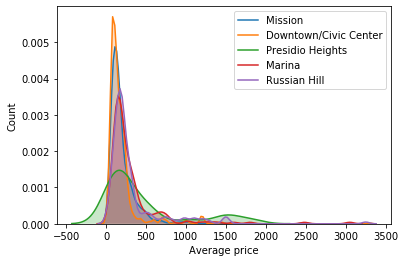

In [119]:
# f, ax = plt.subplots(figsize=(8, 7))
# neighbourhoods = np.random.choice(df['neighbourhood'].unique(), 10, replace=False)
neighbourhoods = ['Mission','Downtown/Civic Center','Presidio Heights', 'Marina','Russian Hill']

for n in neighbourhoods:
    sns.kdeplot(np.exp(df[df['neighbourhood_cleansed'] == n]["price"]),shade=True, label=n)
plt.xlabel("Average price")
plt.ylabel("Count")
plt.show()

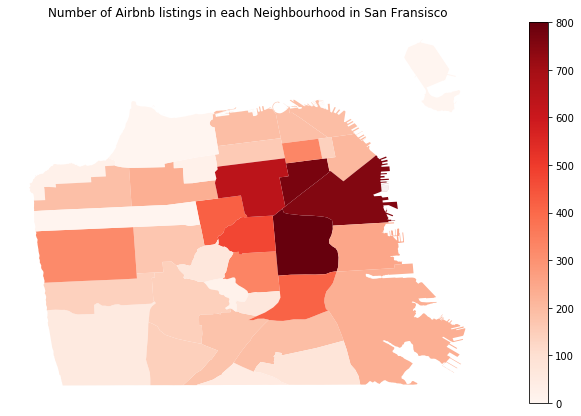

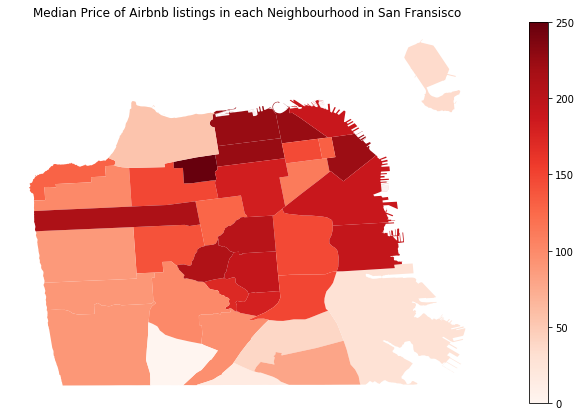

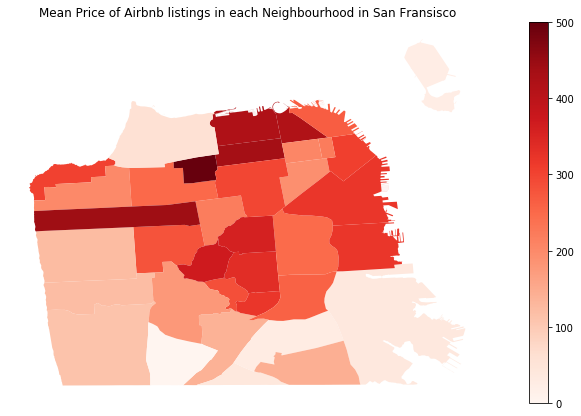

In [120]:
cmap='Reds'
fsize=(15,7)

# plotting the number of listings
fig1, ax1=plt.subplots(1, figsize=fsize)
df_neighbor_map.plot(column='num_of_listings', cmap=cmap, ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Neighbourhood in San Fransisco')
fig1.colorbar(plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=0, vmax=800)), ax=ax1)
plt.savefig('Number of Airbnb listings in each Neighbourhood in San Fransisco.png')
plt.show()


# plotting median price
fig2, ax2=plt.subplots(1, figsize=fsize)
df_neighbor_map.plot(column='median_price', cmap=cmap, ax=ax2)
ax2.axis('off')
ax2.set_title('Median Price of Airbnb listings in each Neighbourhood in San Fransisco')
fig2.colorbar(plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=0, vmax=250)), ax=ax2)
plt.savefig('Median Price of Airbnb listings in each Neighbourhood in San Fransisco.png')
plt.show()


# plotting mean price
fig3, ax3=plt.subplots(1, figsize=fsize)
df_neighbor_map.plot(column='mean_price', cmap=cmap, ax=ax3)
ax3.axis('off')
ax3.set_title('Mean Price of Airbnb listings in each Neighbourhood in San Fransisco')
fig3.colorbar(plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=0, vmax=500)), ax=ax3)
plt.savefig('Mean Price of Airbnb listings in each Neighbourhood in San Fransisco.png')
plt.show()

### - Does the listing price vary over time ?

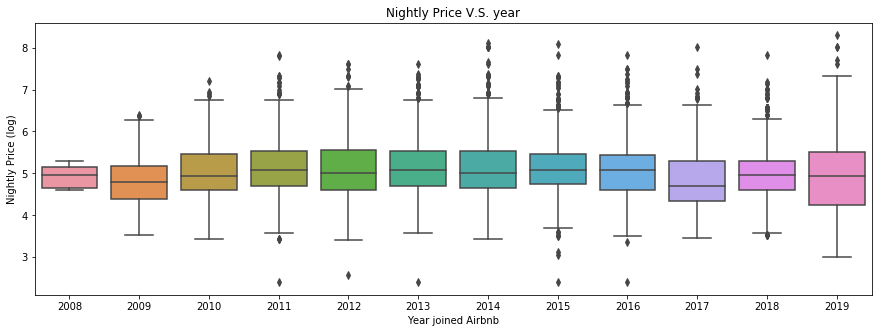

In [121]:
plt.figure(figsize=(15,5))
sns.boxplot(df['host_since'].dt.year, df['price'])
plt.xlabel('Year joined Airbnb')
plt.ylabel('Nightly Price (log)')
plt.title('Nightly Price V.S. year')
plt.savefig('Nightly Price V.S. year_box.png')
plt.show()

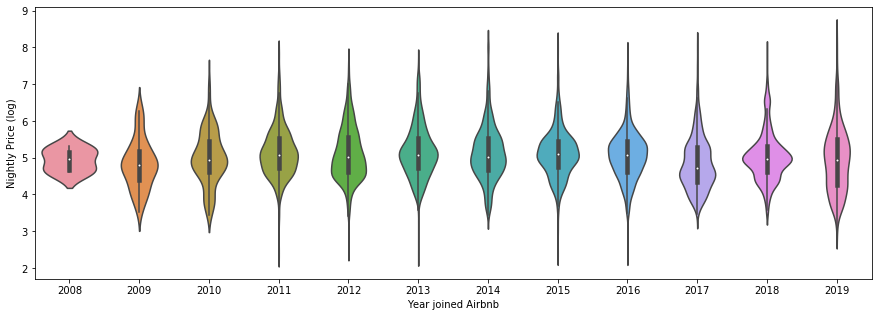

In [122]:
f, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(df['host_since'].dt.year, df['price'])
plt.xlabel('Year joined Airbnb')
plt.ylabel('Nightly Price (log)')
plt.savefig('Nightly Price V.S. year_violin.png')
# print(df.groupby(df['host_since'].dt.year).agg({"price":"median"}).sort_values("price", ascending=True))

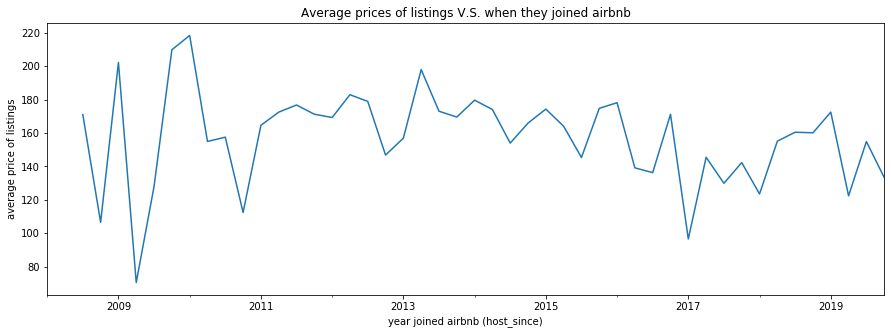

In [123]:
# average price of listings each quarter
minx=min(df['host_since'])
maxx=max(df['host_since'])

plt.figure(figsize=(15,5))
np.exp(df.set_index('host_since').price.resample('QS').mean()).plot()  
plt.title('Average prices of listings V.S. when they joined airbnb')
plt.xlim(minx, maxx) # Limiting to whole months
plt.xlabel('year joined airbnb (host_since)')
plt.ylabel('average price of listings')
plt.show()

### - Does the number of new listings vary over the years or even within a year?

In [124]:
# Creating dataframes for time series analysis
host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
host_since = host_since.rename(columns={0: 'hosts'})
host_since.index.rename('month', inplace=True)
first_review = first_review.rename(columns={0: 'reviews'})
first_review.index.rename('month', inplace=True)

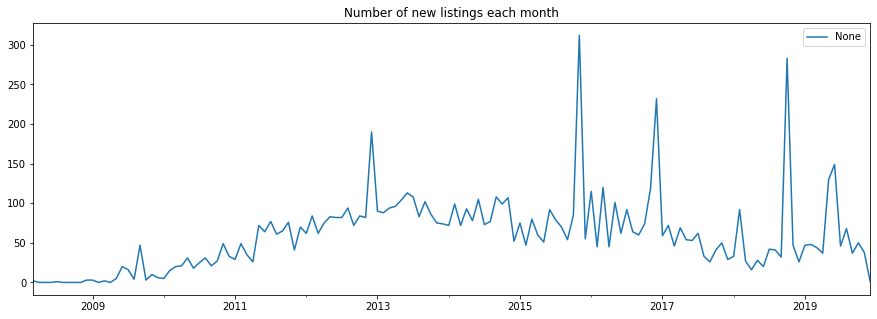

In [125]:
# get the range of xlime

plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot()  # ‘MS’： MonthBegin
plt.title('Number of new listings each month')
plt.legend()
plt.xlim(minx, maxx) # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [126]:
def time_decomposition(df, title=''):
    # decompose the time series
    decom=seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decom.trend
    seasonal = decom.seasonal
    residual = decom.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(title+'.png')

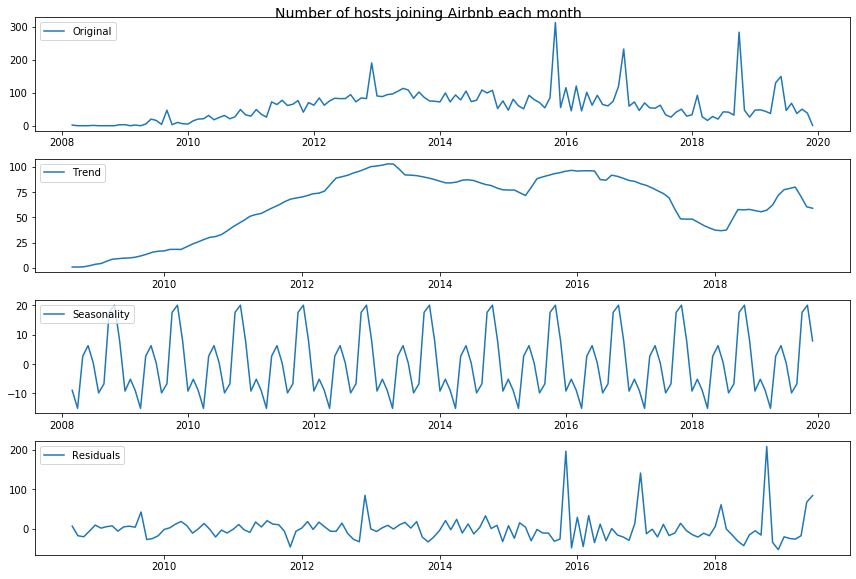

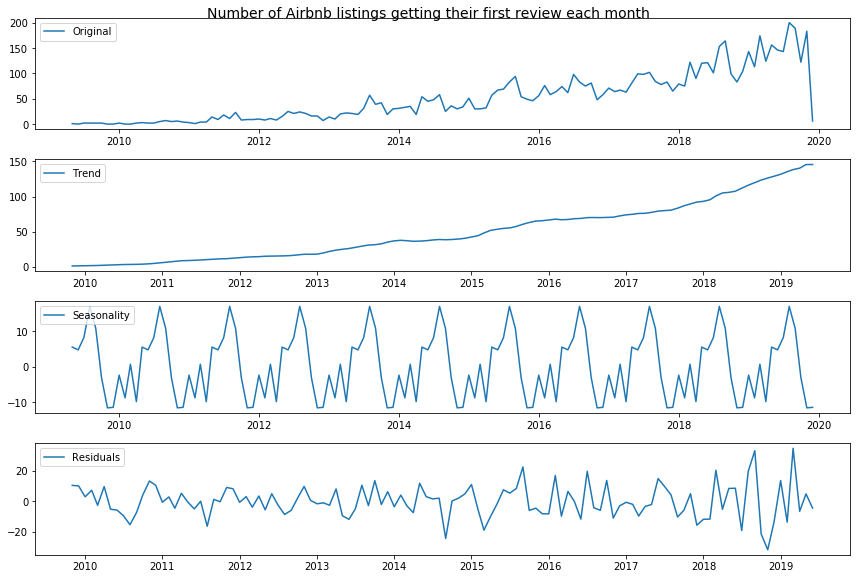

In [127]:
time_decomposition(host_since, title='Number of hosts joining Airbnb each month')
time_decomposition(first_review, title='Number of Airbnb listings getting their first review each month')

### - Do the number of accommodates, bathrooms, bed type, room_type, property types have any effect on the price?
### - what is the average/median prices?
#### bed_type

*** Mean prices of listings with different types of beds:
bed_type
Airbed           101.240961
Couch            229.181854
Futon            113.781651
Pull-out Sofa    148.833282
Real Bed         158.050844
Name: price, dtype: float64


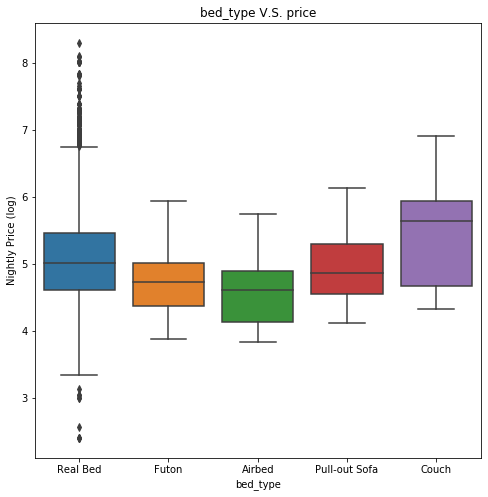

In [128]:
print('*** Mean prices of listings with different types of beds:')
print(np.exp(df.groupby(['bed_type']).price.mean())-1)


plt.figure(figsize=(8,8))
sns.boxplot(df['bed_type'], df['price'])
plt.ylabel('Nightly Price (log)')
plt.title('bed_type V.S. price')
plt.savefig('bed_type V.S. price_box.png')
plt.show()

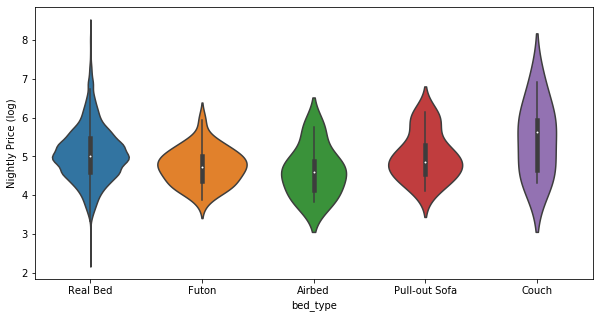

In [129]:
f, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x="bed_type", y="price", data=df)
plt.ylabel('Nightly Price (log)')
plt.savefig('bed_type V.S. price_violin.png')
# print(df.groupby(["bed_type"]).agg({"price":"median"}).sort_values("price", ascending=True))

#### room_type

*** Mean prices of listings with different types of rooms:
room_type
Entire home/apt    210.918673
Hotel room         163.613181
Private room       111.457029
Shared room         45.321394
Name: price, dtype: float64


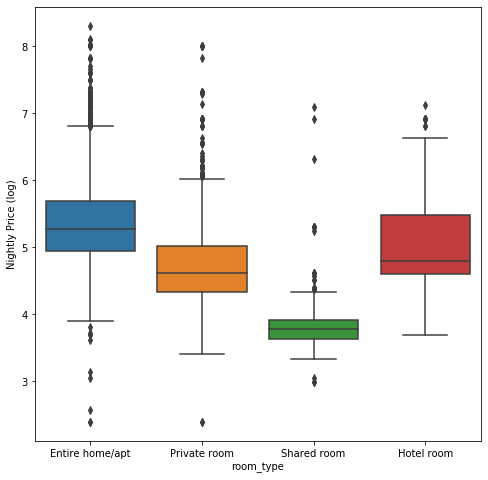

In [130]:
print('*** Mean prices of listings with different types of rooms:')
print(np.exp(df.groupby(['room_type']).price.mean())-1)


plt.figure(figsize=(8,8))
sns.boxplot(df['room_type'], df['price'])
plt.ylabel('Nightly Price (log)')
plt.savefig('room_type V.S. price_box.png')
plt.show()

                    price
room_type                
Shared room      3.772695
Private room     4.615121
Hotel room       4.787492
Entire home/apt  5.278115


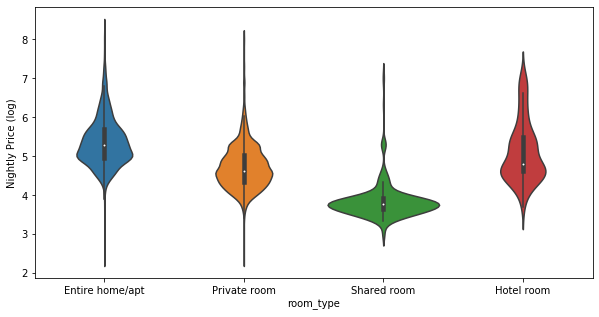

In [131]:
f, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x="room_type", y="price", data=df)
plt.ylabel('Nightly Price (log)')
plt.savefig('room_type V.S. price_violin.png')
print(df.groupby(["room_type"]).agg({"price":"median"}).sort_values("price", ascending=True))

#### property_type

*** Mean prices of different kind of properties:
property_type
Apartment      152.039164
Condominium    212.525308
Hotel          161.449050
House          147.903988
Other          187.951937
Name: price, dtype: float64


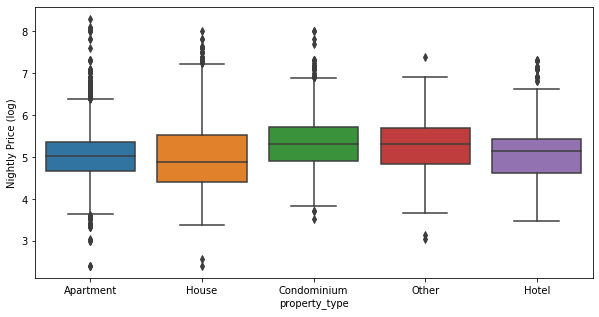

In [132]:
print('*** Mean prices of different kind of properties:')
print(np.exp(df.groupby(['property_type']).price.mean())-1)


plt.figure(figsize=(10,5))
sns.boxplot(df['property_type'], df['price'])
plt.ylabel('Nightly Price (log)')
plt.savefig('property_type V.S. price _box.png')
plt.show()

                  price
property_type          
House          4.875197
Apartment      5.017280
Hotel          5.135798
Other          5.298317
Condominium    5.303305


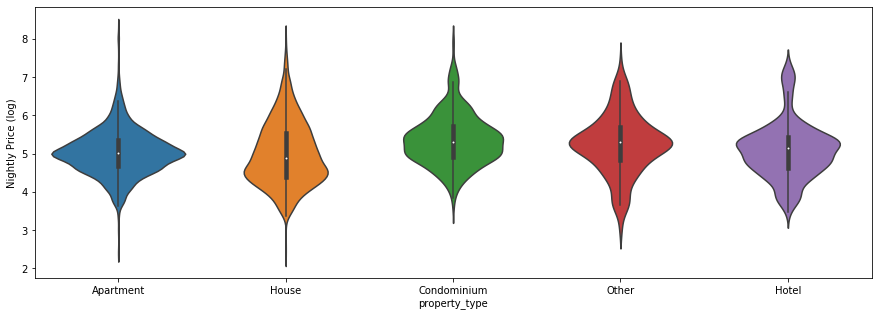

In [133]:
f, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(x="property_type", y="price", data=df)
plt.ylabel('Nightly Price (log)')
plt.savefig('property_type V.S. price _violin.png')
print(df.groupby(["property_type"]).agg({"price":"median"}).sort_values("price", ascending=True))

#### accommodates

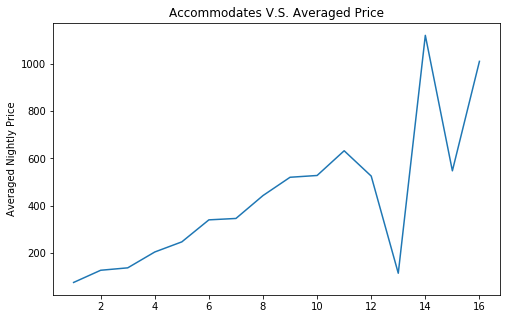

In [134]:
plt.figure(figsize=(8,5))
plt.plot(np.exp(df.groupby(['accommodates']).price.mean())-1)
plt.ylabel('Averaged Nightly Price')
plt.title('Accommodates V.S. Averaged Price')
plt.savefig('accommodates V.S. Averaged Price.png')
plt.show()

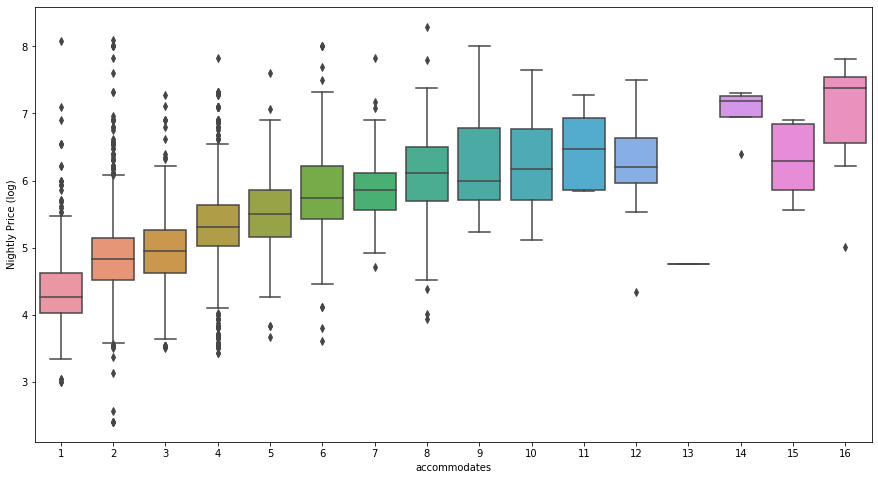

In [135]:
plt.figure(figsize=(15,8))
sns.boxplot(df['accommodates'], df['price'])
plt.ylabel('Nightly Price (log)')
plt.savefig('accommodates V.S. price _box.png')
plt.show()

                 price
accommodates          
1             4.262680
13            4.753590
2             4.836282
3             4.948760
4             5.303305
5             5.503129
6             5.739793
7             5.857933
9             5.992713
8             6.111467
10            6.165418
12            6.196444
15            6.284134
11            6.475551
14            7.188320
16            7.378384


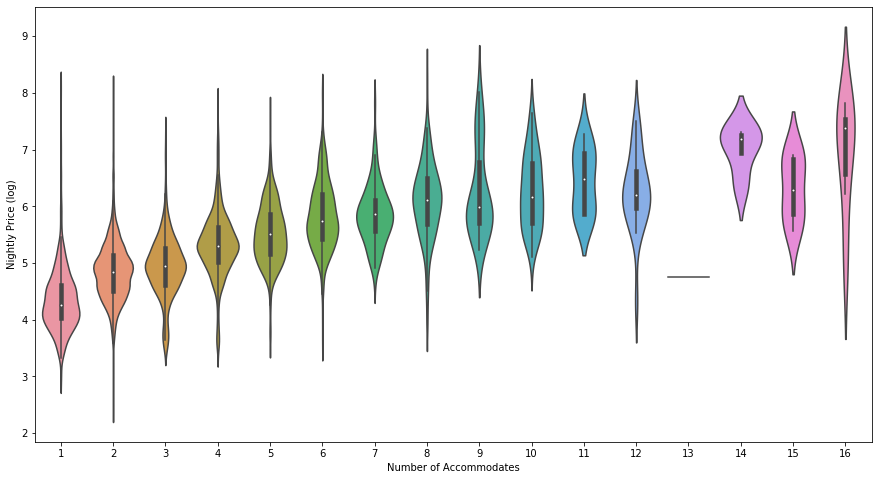

In [136]:
f, ax = plt.subplots(figsize=(15, 8))
sns.violinplot(x="accommodates", y="price", data=df)
plt.xlabel('Number of Accommodates')
plt.ylabel('Nightly Price (log)')
plt.savefig('Accommodates V.S. price_violin.png')
print(df.groupby(["accommodates"]).agg({"price":"median"}).sort_values("price", ascending=True))

#### bathrooms

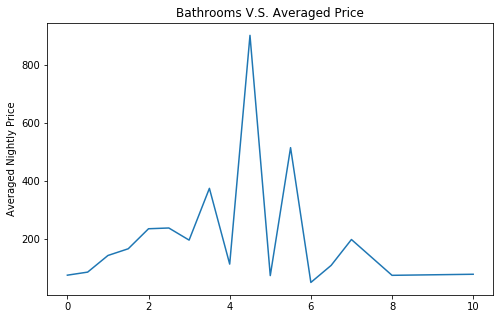

In [137]:
plt.figure(figsize=(8,5))
plt.plot(np.exp(df.groupby(['bathrooms']).price.mean())-1)
plt.ylabel('Averaged Nightly Price')
plt.title('Bathrooms V.S. Averaged Price')
plt.savefig('Bathrooms V.S. Averaged Price.png')
plt.show()

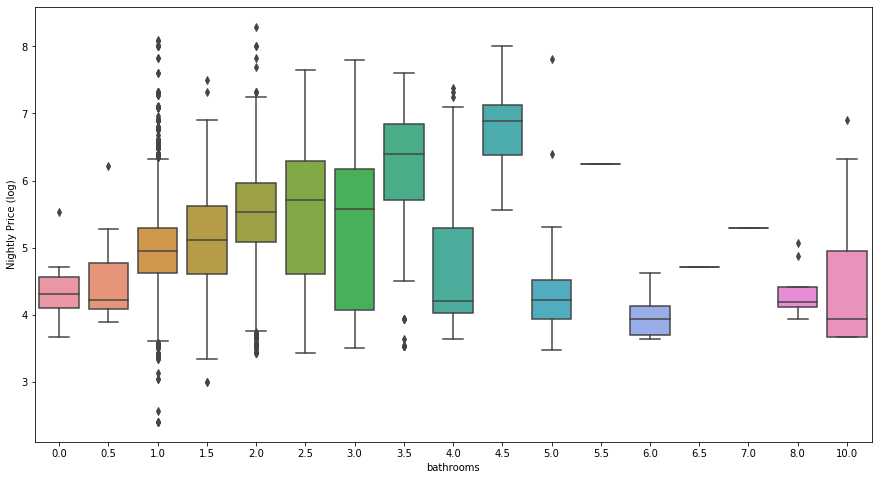

In [138]:
plt.figure(figsize=(15,8))
sns.boxplot(df['bathrooms'], df['price'])
plt.ylabel('Nightly Price (log)')
plt.savefig('bathrooms V.S. price _box.png')
plt.show()

              price
bathrooms          
10.0       3.931826
6.0        3.931826
8.0        4.189655
4.0        4.197174
0.5        4.210781
5.0        4.219508
0.0        4.304065
6.5        4.709530
1.0        4.948760
1.5        5.105945
7.0        5.298317
2.0        5.525453
3.0        5.581471
2.5        5.713711
5.5        6.246107
3.5        6.388561
4.5        6.883463


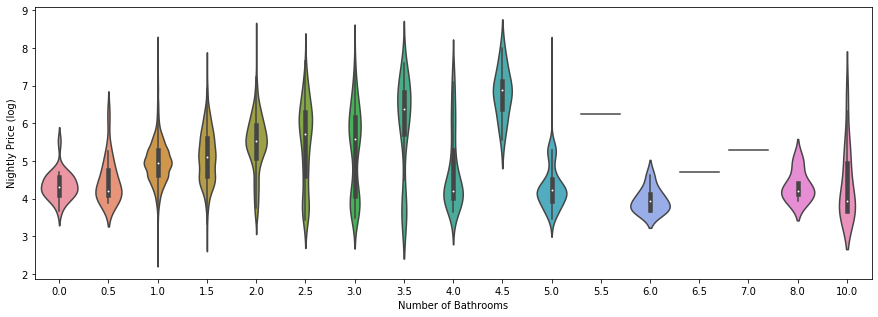

In [139]:
f, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(x="bathrooms", y="price", data=df)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Nightly Price (log)')
plt.savefig('Bathrooms V.S. year_violin.png')
print(df.groupby(["bathrooms"]).agg({"price":"median"}).sort_values("price", ascending=True))

### - What amenities should a property provide?

In [140]:
mean_price_amen=[]
for col in new_col:
    mean_price_amen.append(np.exp(df[df[col]==1].price.mean())-1)
mean_price_amen=pd.DataFrame(mean_price_amen, columns=['Mean_Price'], index=new_col)
mean_price_amen.sort_values(by=['Mean_Price'],ascending=False).head()

,Mean_Price
air_conditioning,347.976602
ev_charger,234.979993
gym,213.453014
family_kid_friendly,199.222788
beach,197.294706


### - Does cleaning fee and security deposit have an influence on price?

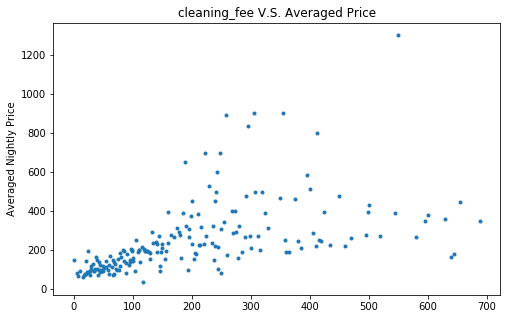

In [141]:
plt.figure(figsize=(8,5))
plt.plot(np.exp(df.groupby(['cleaning_fee']).price.mean())-1, '.')
plt.ylabel('Averaged Nightly Price')
plt.title('cleaning_fee V.S. Averaged Price')
plt.savefig('cleaning_fee V.S. Averaged Price.png')
plt.show()

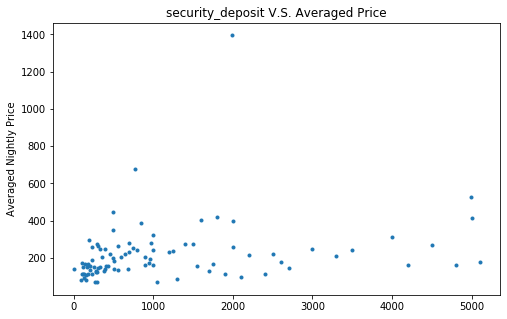

In [142]:
plt.figure(figsize=(8,5))
plt.plot(np.exp(df.groupby(['security_deposit']).price.mean())-1, '.')
plt.ylabel('Averaged Nightly Price')
plt.title('security_deposit V.S. Averaged Price')
plt.savefig('security_deposit V.S. Averaged Price.png')
plt.show()

### - Does it worth it to be a superhost, or be verified?

                      price
host_is_superhost          
0.0                5.047083
1.0                5.095940


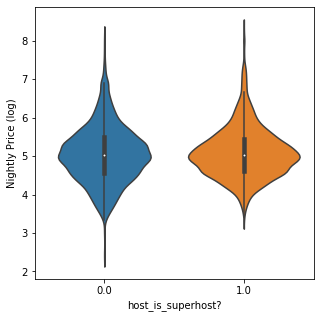

In [143]:
f, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(x="host_is_superhost", y="price", data=df)
plt.xlabel('host_is_superhost?')
plt.ylabel('Nightly Price (log)')
plt.savefig('host_is_superhost V.S. year_violin.png')
print(df.groupby(["host_is_superhost"]).agg({"price":"mean"}).sort_values("price", ascending=True))

                           price
host_identity_verified          
0                       4.984949
1                       5.148452


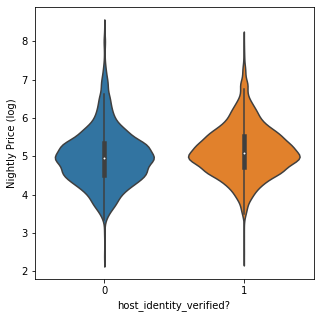

In [144]:
f, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(x="host_identity_verified", y="price", data=df)
plt.xlabel('host_identity_verified?')
plt.ylabel('Nightly Price (log)')
plt.savefig('host_identity_verified V.S. year_violin.png')
print(df.groupby(["host_identity_verified"]).agg({"price":"mean"}).sort_values("price", ascending=True))

## visualization done, drop all unnecessary features

In [145]:
# drop features in drop_corr_list
flatted_tobedeleted_col = [l[0] for l in tobedeleted_col] 
df.drop(flatted_tobedeleted_col, axis=1, inplace=True)

# More cleanning -- skewed features

In [146]:
# numeric_feats = df.select_dtypes(['float64','int64']).columns
# skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness = skewness[abs(skewness.Skew)>0.75]
# skewed_feats = skewed_feats.index
# print("There are {} skewed numerical features to transform".format(skewness.shape[0]))
# skewed_feats

In [147]:
# skewed_feats = ['extra_people', 'bathrooms', 'host_total_listings_count',
#                 'security_deposit', 'number_of_reviews', 'minimum_nights', 
#                 'accommodates', 'cleaning_fee', 'maximum_nights_avg_ntm']

# # log1p 
# for col in skewed_feats:
#     df[col]=np.log1p(df[col])   #  df[col] = boxcox1p(df[col], 0.15)
    
# df[skewed_feats].hist(figsize=(15,15));


# ## boxcox1p 
# # for col in skewed_feats:
# #     df[col] = boxcox1p(df[col], 0.15)
# # df[skewed_feats].hist(figsize=(15,15));

## Dummy Dataframe & More Correlation Studies

### Generate Dummied Dataframe

In [148]:
# dataset summary before encoding
categorical_features=df.select_dtypes(['object']).columns
for col in categorical_features:
    print('---------',col,'---------')
    print(df[col].value_counts())

print(df.shape)

--------- host_response_time ---------
within an hour        5031
within a few hours    1758
unknown                929
within a day           663
a few days or more      67
Name: host_response_time, dtype: int64
--------- host_response_rate ---------
99-100%    5416
90-99%     1199
unknown     929
80-90%      492
<80%        412
Name: host_response_rate, dtype: int64
--------- neighbourhood_cleansed ---------
Mission                  783
Downtown/Civic Center    754
South of Market          738
Western Addition         629
Castro/Upper Market      466
Haight Ashbury           411
Bernal Heights           407
Noe Valley               330
Nob Hill                 323
Outer Sunset             314
Potrero Hill             247
Inner Richmond           226
Bayview                  225
Financial District       203
Marina                   190
North Beach              189
Excelsior                188
Russian Hill             187
Outer Richmond           187
Outer Mission            176
Inner 

(25, 25)


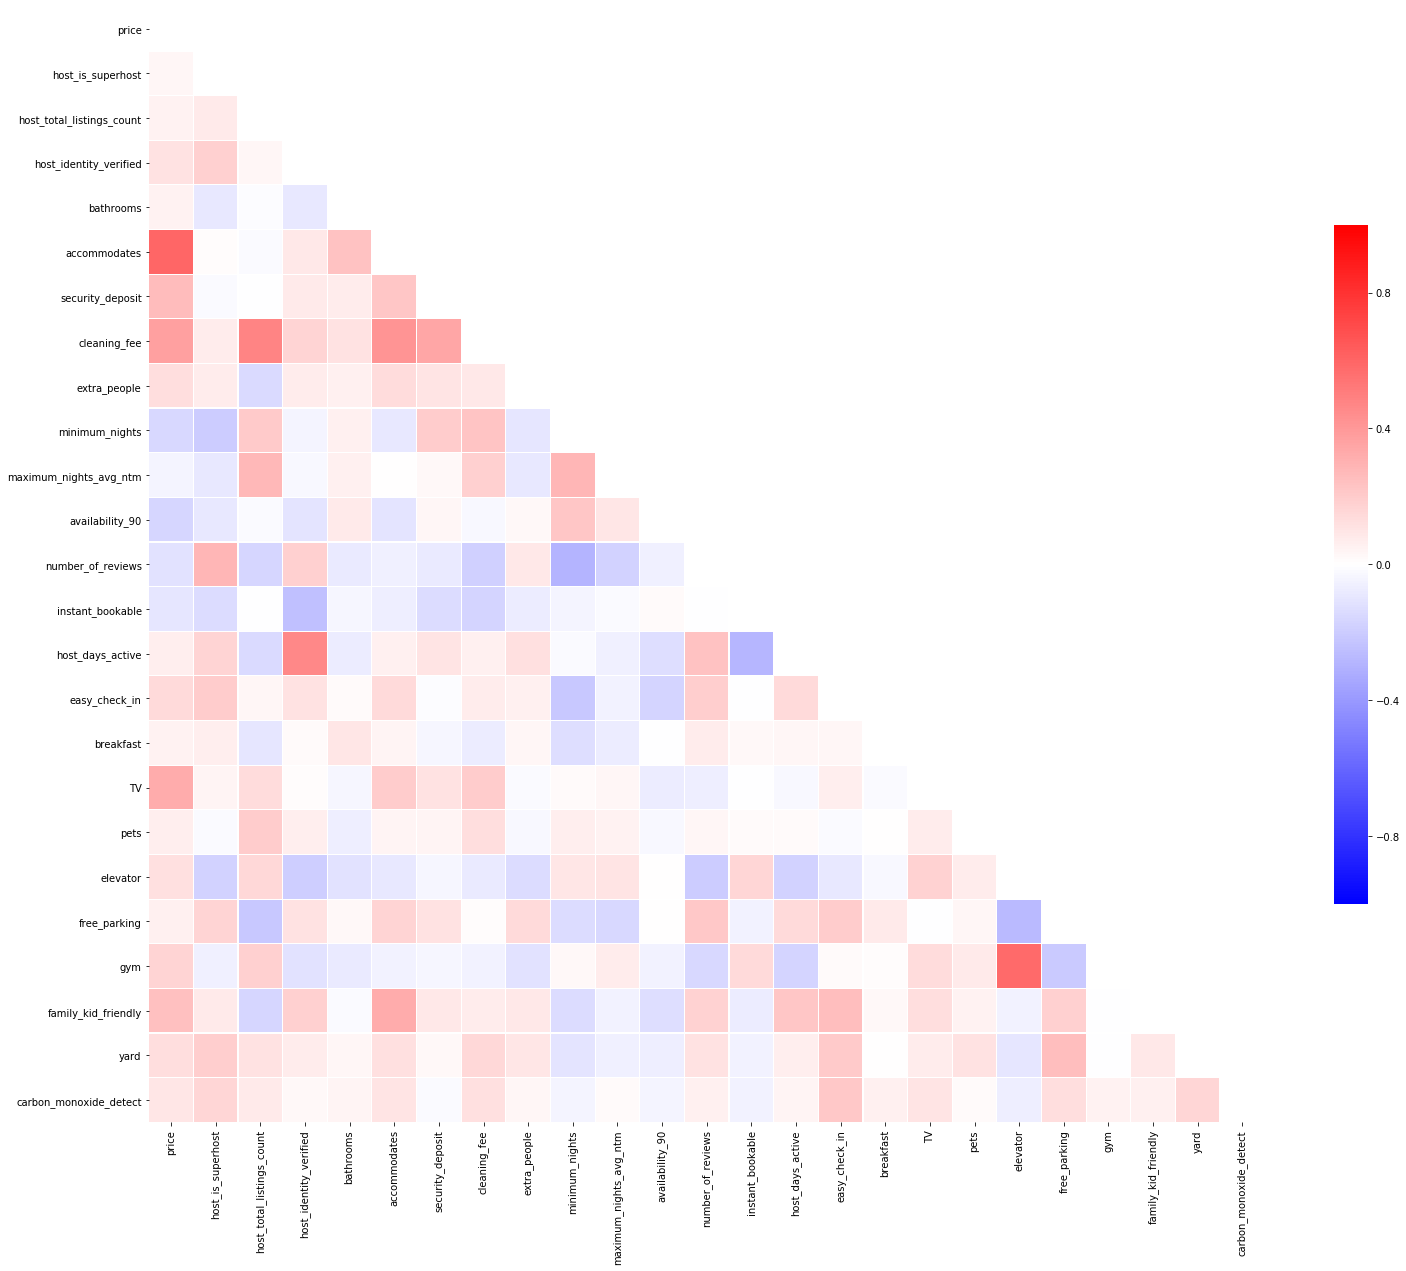

In [149]:
corr=df.corr()
corr_heatmap(corr,'c')

# features with correlation values beyond a threshold
corr_ex=corr[corr>0.6]
rows,cols=np.where(corr_ex.isna()==0)
for (i,j) in zip(rows,cols):
    if (i>j):
        print(corr_ex.index.to_list()[i],'---',corr_ex.columns[j],'---',corr.iloc[i,j])

In [150]:
df_dummy=dummied_df(df)

Index(['host_response_time', 'host_response_rate', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'time_since_first_review',
       'time_since_last_review'],
      dtype='object')


In [151]:
# corr_heatmap(df_dummy, 'df')

#### Only display the part of correlation >= 0.6

In [152]:
corr=df_dummy.corr()
corr_ex=corr[corr>0.7]
rows,cols=np.where(corr_ex.isna()==0)
for (i,j) in zip(rows,cols):
    if (i>j):
        print(corr_ex.index.to_list()[i],'---',corr_ex.columns[j],'---',corr.iloc[i,j])
        
# corr_heatmap(corr_ex,'c')

host_response_rate_unknown --- host_response_time_unknown --- 1.0
review_scores_checkin_unknown --- review_scores_cleanliness_unknown --- 0.9996628610199981
review_scores_location_unknown --- review_scores_cleanliness_unknown --- 0.9996628610199981
review_scores_location_unknown --- review_scores_checkin_unknown --- 1.0
review_scores_value_unknown --- review_scores_cleanliness_unknown --- 0.9996628610199981
review_scores_value_unknown --- review_scores_checkin_unknown --- 1.0
review_scores_value_unknown --- review_scores_location_unknown --- 1.0
time_since_first_review_unknown --- review_scores_cleanliness_unknown --- 0.9851497072536957
time_since_first_review_unknown --- review_scores_checkin_unknown --- 0.9848175748863127
time_since_first_review_unknown --- review_scores_location_unknown --- 0.9848175748863127
time_since_first_review_unknown --- review_scores_value_unknown --- 0.9848175748863127
time_since_last_review_unknown --- review_scores_cleanliness_unknown --- 0.98514970725369

In [153]:
corr=df_dummy.corr()
corr_ex=corr[corr<-0.7]
rows,cols=np.where(corr_ex.isna()==0)
for (i,j) in zip(rows,cols):
    if (i>j):
        print(corr_ex.index.to_list()[i],'---',corr_ex.columns[j],'---',corr.iloc[i,j] )
        
# corr_heatmap(corr_ex,'c')

review_scores_checkin_10 --- review_scores_cleanliness_unknown --- -0.815065503102018
review_scores_checkin_unknown --- review_scores_checkin_10 --- -0.8153403861281369
review_scores_location_unknown --- review_scores_checkin_10 --- -0.8153403861281369
review_scores_value_unknown --- review_scores_checkin_10 --- -0.8153403861281369
time_since_first_review_unknown --- review_scores_checkin_10 --- -0.8029615417735855
time_since_last_review_unknown --- review_scores_checkin_10 --- -0.8029615417735855


In [154]:
print(df_dummy.shape)
df_dummy.drop(['host_response_time_unknown', 'review_scores_cleanliness_unknown','review_scores_checkin_unknown',
              'review_scores_location_unknown', 'time_since_first_review_unknown','time_since_last_review_unknown',
              'review_scores_checkin_10'], axis=1, inplace=True)

(8448, 100)


# ready to output

In [155]:
df.columns

Index(['price', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms', 'accommodates', 'security_deposit',
       'cleaning_fee', 'extra_people', 'minimum_nights',
       'maximum_nights_avg_ntm', 'availability_90', 'number_of_reviews',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'host_days_active', 'easy_check_in', 'breakfast',
       'TV', 'pets', 'elevator', 'free_parking', 'gym', 'family_kid_friendly',
       'yard', 'carbon_monoxide_detect', 'time_since_first_review',
       'time_since_last_review'],
      dtype='object')

In [156]:
df.to_csv('Listing_full_cleaned.csv', index=False)
print(df.shape)

df_dummy.to_csv('Listing_full_cleaned_dummied.csv', index=False)
print(df_dummy.shape)

(8448, 37)
(8448, 93)
